In [1]:
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_ai.Training import train_model
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data, revert_normalization, revert_normalization_prof

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
with_pca = with open('pyfile.txt', 'r') as f:
    # Comment: 
    print(f.readline())
# end readline file
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

SyntaxError: invalid syntax (<ipython-input-1-b35fb183461c>, line 32)

In [ ]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

: 

In [ ]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

: 

In [ ]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

: 

In [ ]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 7
neurons_per_layer = 100
# activation_hidden =  # tanh, sigmoid # 'relu'
# activation_hidden = 'sigmoid' #best for NoPCA
activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

: 

In [ ]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

: 

In [ ]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

: 

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    predictions = model(inputs.to(device))
    print("Predictions Shape:", predictions.shape)

# Comparing prediction to actual label for the first data point and save
plt.figure()
plt.plot(predictions[0].cpu().numpy(), label="Prediction", linewidth=0.3, color="red")
plt.plot(labels[0].numpy(), label="Ground Truth", linewidth=0.3, color="blue")
plt.legend()
plt.grid()
plt.title("Prediction VS Ground Truth - First case - " + model_name)
plt.savefig('comparison_' + model_name+ '.png', dpi=600)
plt.close()

: 

In [ ]:
# dataset = revert_normalization(dataset, data_folder)
inoutdims = dataset.get_inout_dims()
for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

: 

In [2]:
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_ai.Training import train_model
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data, revert_normalization, revert_normalization_prof

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
with_pca = False
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

2023-09-03 12:41:38.731373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 12:41:39.459424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device:  cuda


In [3]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

In [4]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

Total number of training samples:  4401
Total number of validation samples:  489
Done loading data!


In [5]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

Input Shape: torch.Size([400, 2])
Labels Shape: torch.Size([400, 4002])


In [6]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 7
neurons_per_layer = 100
# activation_hidden =  # tanh, sigmoid # 'relu'
# activation_hidden = 'sigmoid' #best for NoPCA
activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

DenseModel: hidden_layers:7, neurons_per_layer:100, activation_hidden:relu, activation_output:linear


In [7]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

Training model...


In [ ]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    predictions = model(inputs.to(device))
    print("Predictions Shape:", predictions.shape)

# Comparing prediction to actual label for the first data point and save
plt.figure()
plt.plot(predictions[0].cpu().numpy(), label="Prediction", linewidth=0.3, color="red")
plt.plot(labels[0].numpy(), label="Ground Truth", linewidth=0.3, color="blue")
plt.legend()
plt.grid()
plt.title("Prediction VS Ground Truth - First case - " + model_name)
plt.savefig('comparison_' + model_name+ '.png', dpi=600)
plt.close()

In [ ]:
# dataset = revert_normalization(dataset, data_folder)
inoutdims = dataset.get_inout_dims()
for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

In [1]:
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_ai.Training import train_model
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data, revert_normalization, revert_normalization_prof

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
with_pca = True
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

2023-09-03 12:47:56.858170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 12:47:57.472935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device:  cuda


In [2]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

Temp PCA shape: (100, 4890), original shape: (100, 4890)
Explained Variance Ratio: 0.999637
Sal PCA shape: (100, 4890), original shape: (100, 4890)
Explained Variance Ratio: 0.999726


In [3]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

Total number of training samples:  4401
Total number of validation samples:  489
Done loading data!


In [4]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

Input Shape: torch.Size([400, 2])
Labels Shape: torch.Size([400, 200])


In [5]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 7
neurons_per_layer = 100
# activation_hidden =  # tanh, sigmoid # 'relu'
# activation_hidden = 'sigmoid' #best for NoPCA
activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

DenseModel: hidden_layers:7, neurons_per_layer:100, activation_hidden:relu, activation_output:linear


In [6]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

Training model...
Epoch: 1, Val loss: 0.001567 Training loss: 0.0025


/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/proj_ai/proj_models.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.batch_nomalization and l1.shape[0] > 1:


Epoch: 2, Val loss: 0.000977 Training loss: 0.0013
Epoch: 3, Val loss: 0.000588 Training loss: 0.0009
Epoch: 4, Val loss: 0.000494 Training loss: 0.0008
Epoch: 5, Val loss: 0.000460 Training loss: 0.0008
Epoch: 6, Val loss: 0.000462 Training loss: 0.0009
Epoch: 7, Val loss: 0.000646 Training loss: 0.0007
Epoch: 8, Val loss: 0.000463 Training loss: 0.0006
Epoch: 9, Val loss: 0.000501 Training loss: 0.0010
Epoch: 10, Val loss: 0.001584 Training loss: 0.0007
Epoch: 11, Val loss: 0.000557 Training loss: 0.0006
Epoch: 12, Val loss: 0.000475 Training loss: 0.0006
Epoch: 13, Val loss: 0.001117 Training loss: 0.0007
Epoch: 14, Val loss: 0.000570 Training loss: 0.0006
Epoch: 15, Val loss: 0.000435 Training loss: 0.0006
Epoch: 16, Val loss: 0.000428 Training loss: 0.0006
Epoch: 17, Val loss: 0.000488 Training loss: 0.0007
Epoch: 18, Val loss: 0.000837 Training loss: 0.0011
Epoch: 19, Val loss: 0.002075 Training loss: 0.0006
Epoch: 20, Val loss: 0.000415 Training loss: 0.0009
Epoch: 21, Val loss:

In [7]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

In [8]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    predictions = model(inputs.to(device))
    print("Predictions Shape:", predictions.shape)

# Comparing prediction to actual label for the first data point and save
plt.figure()
plt.plot(predictions[0].cpu().numpy(), label="Prediction", linewidth=0.3, color="red")
plt.plot(labels[0].numpy(), label="Ground Truth", linewidth=0.3, color="blue")
plt.legend()
plt.grid()
plt.title("Prediction VS Ground Truth - First case - " + model_name)
plt.savefig('comparison_' + model_name+ '.png', dpi=600)
plt.close()

Predictions Shape: torch.Size([400, 200])


Batch size: 400, Input size: torch.Size([489, 2]), Output size: torch.Size([489, 200])


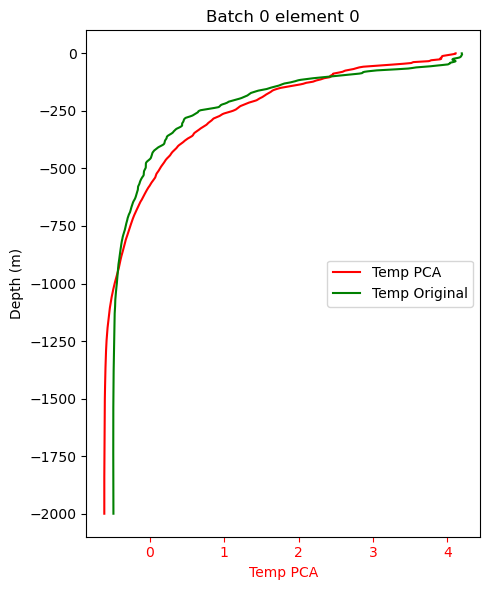

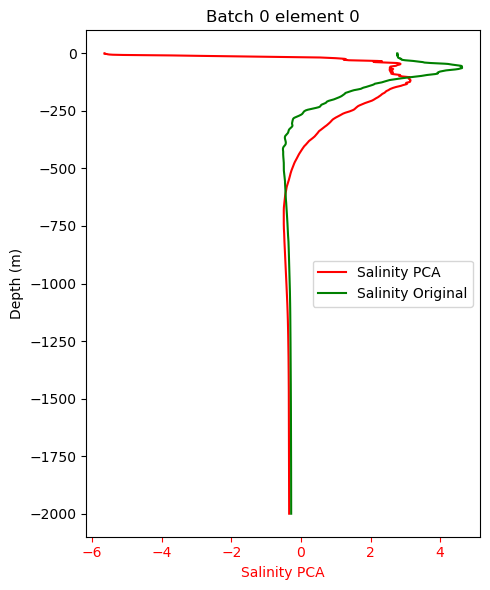

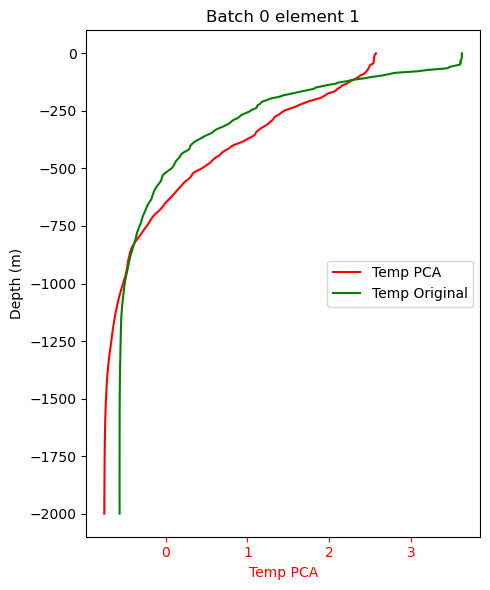

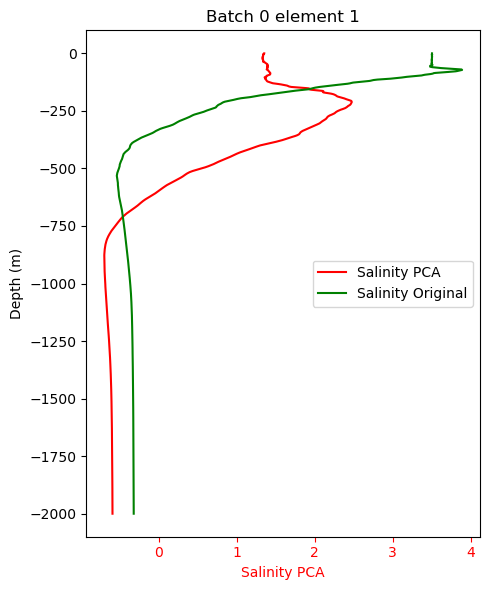

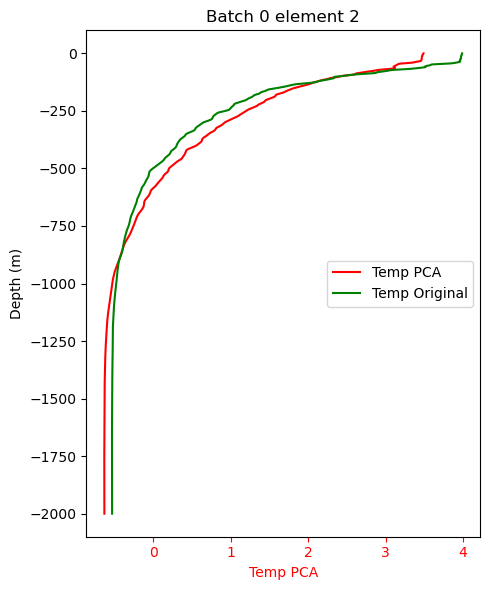

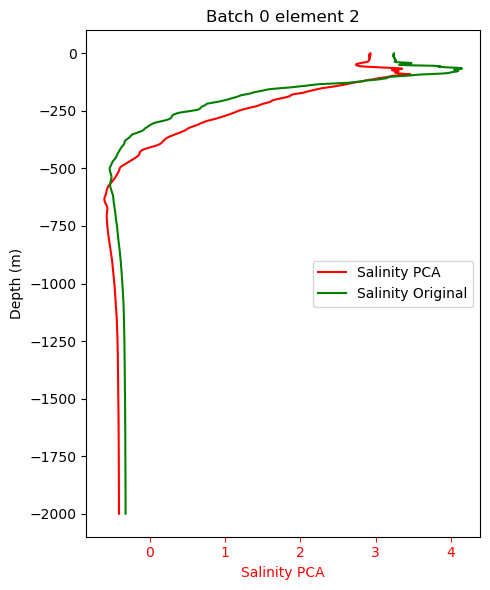

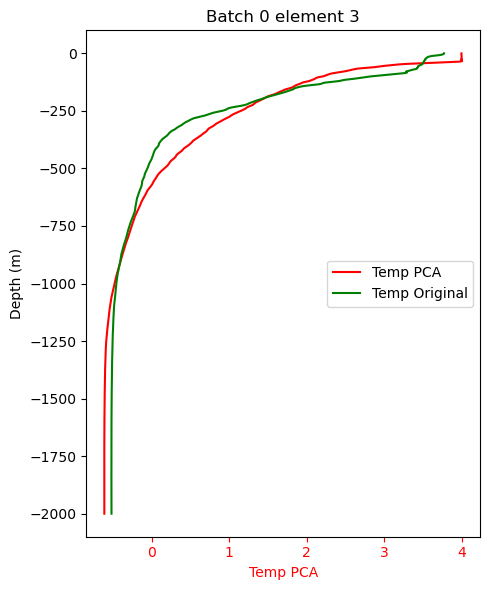

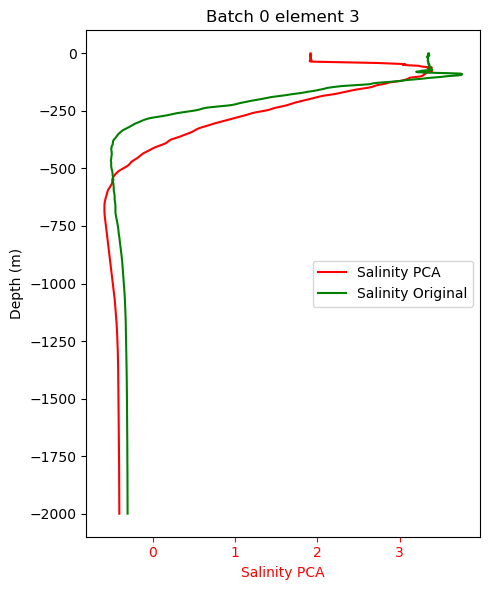

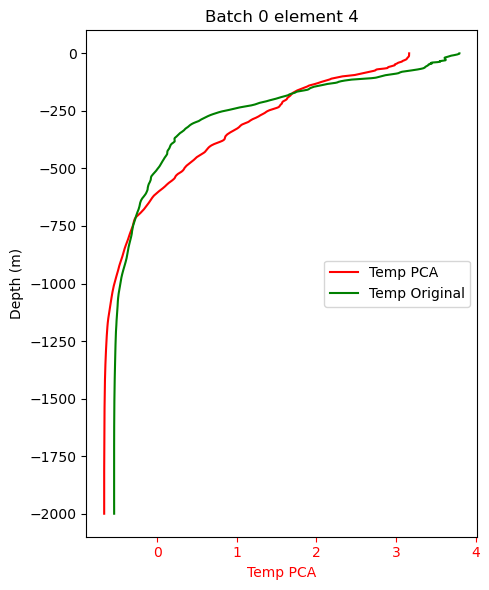

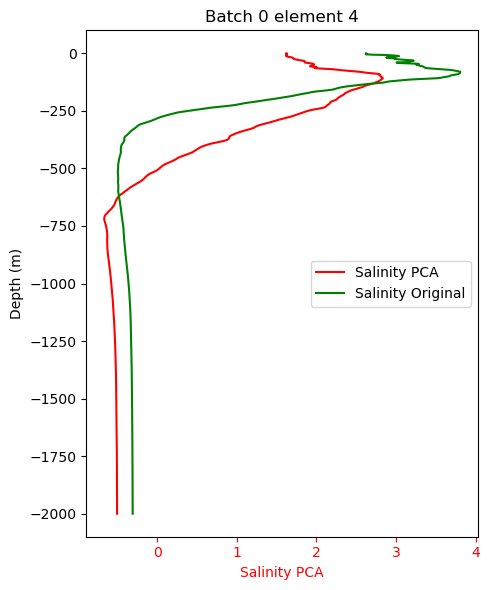

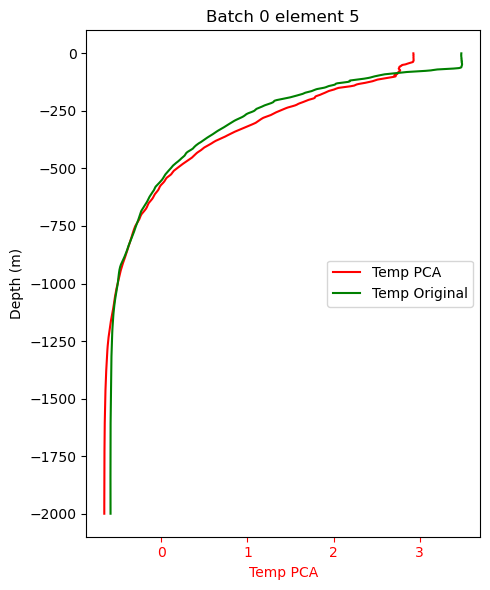

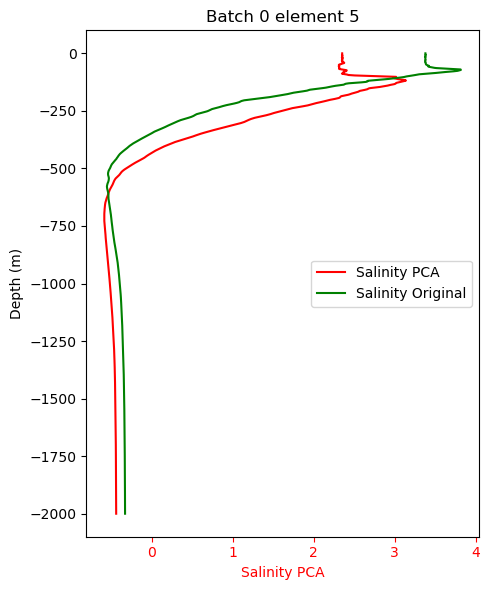

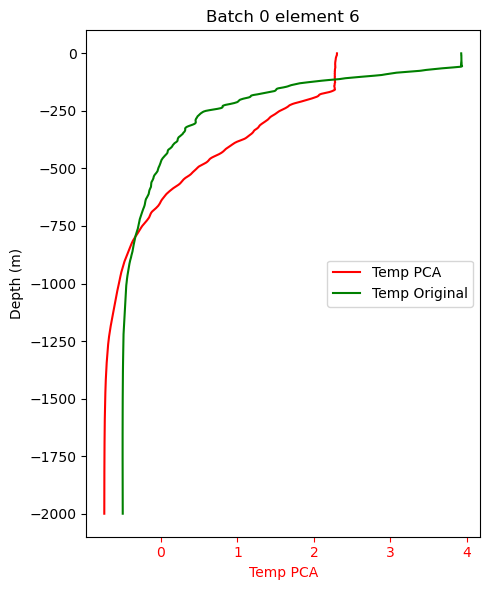

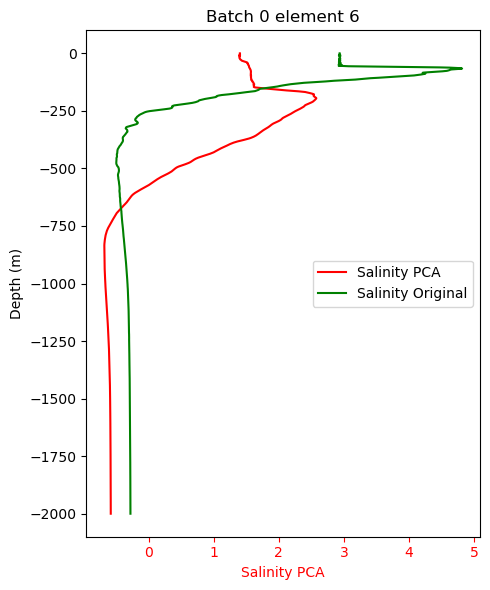

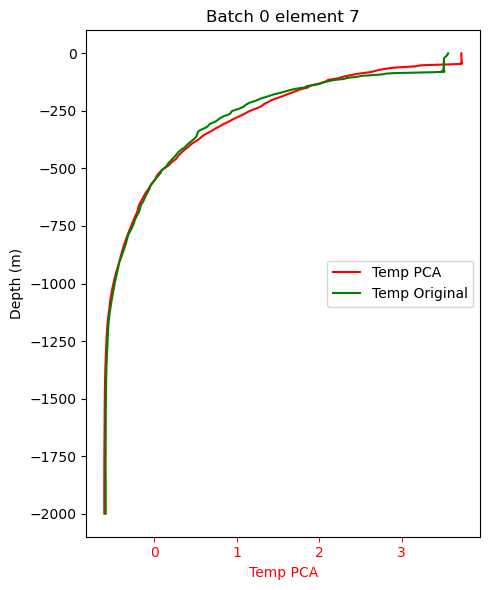

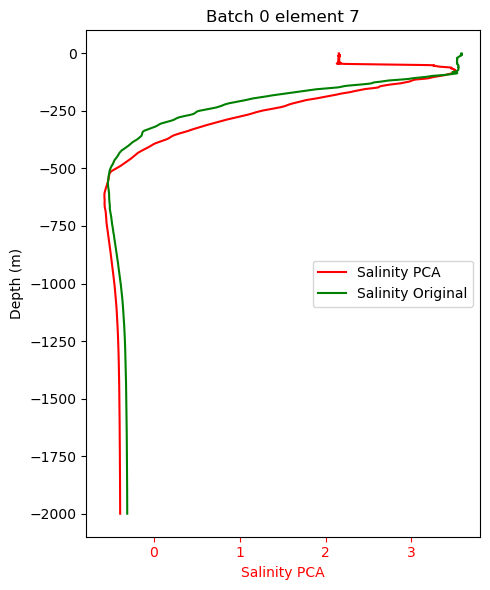

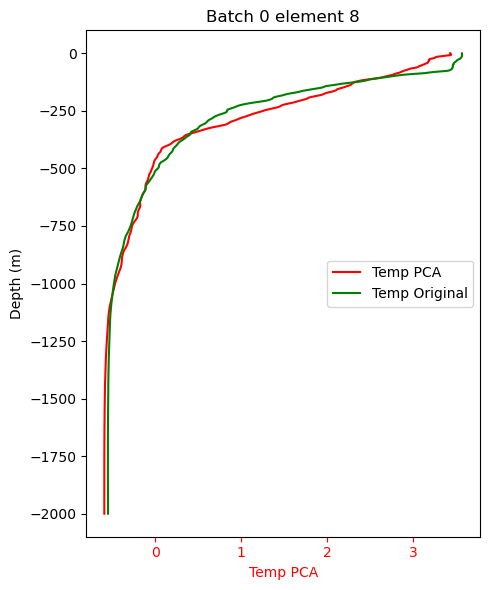

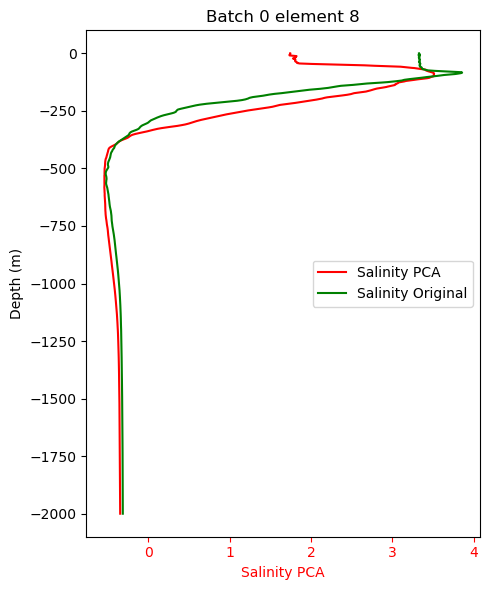

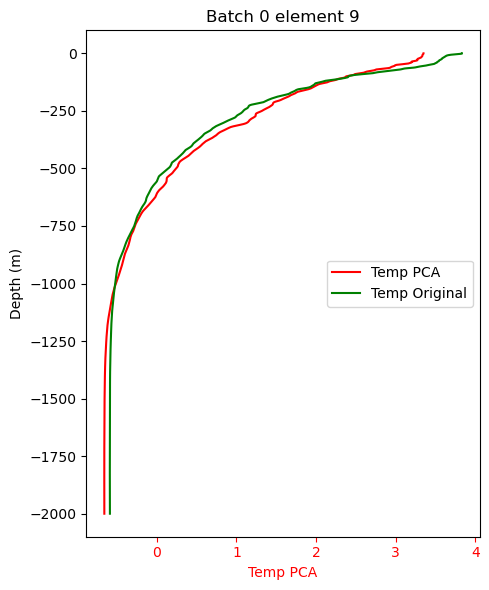

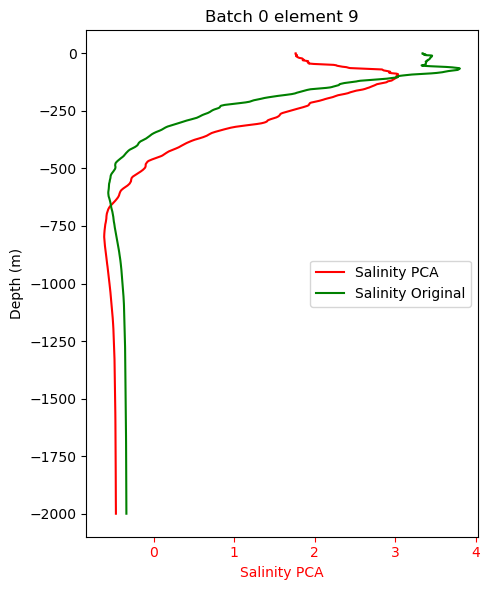

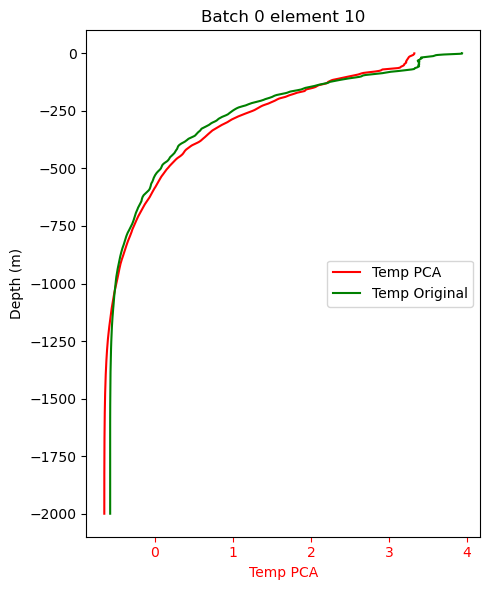

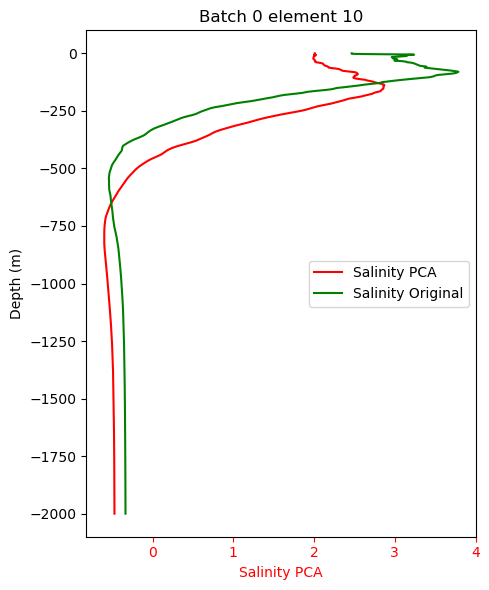

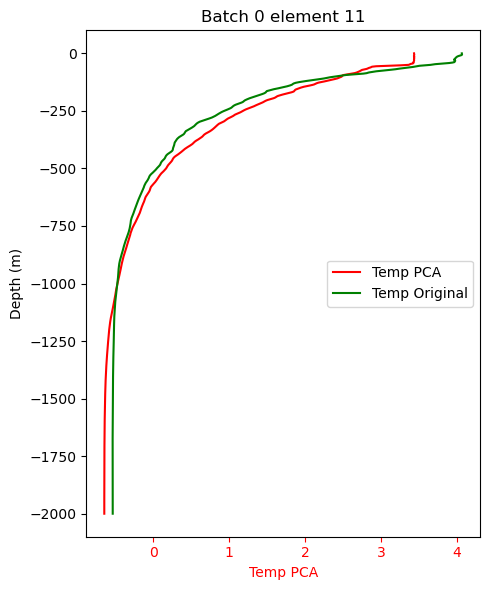

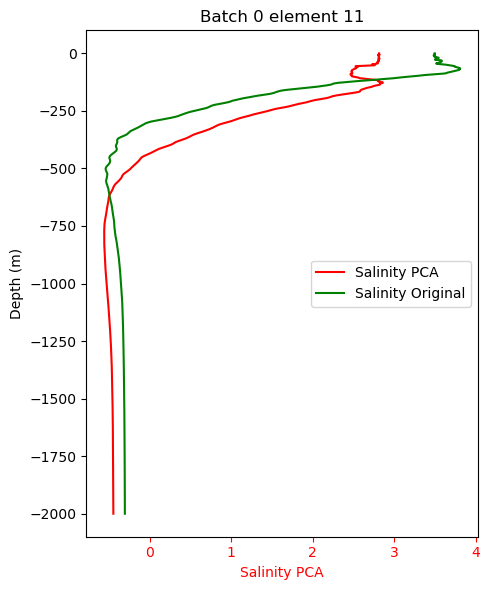

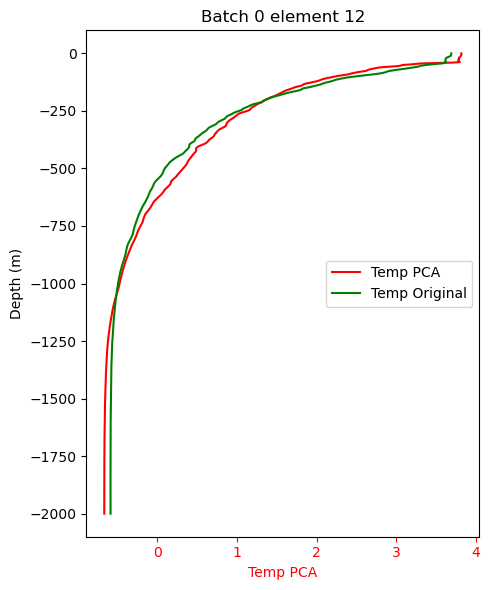

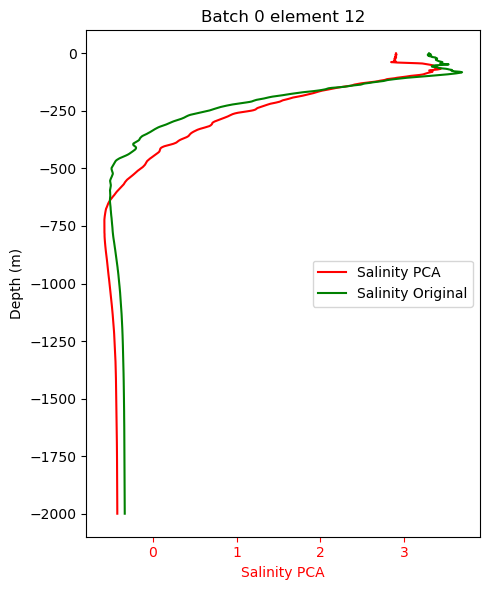

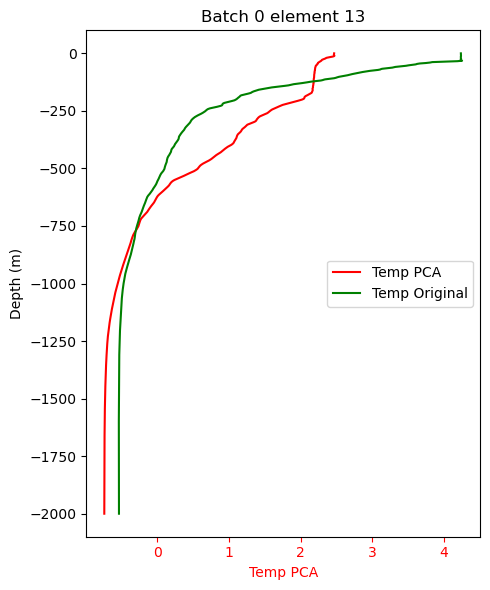

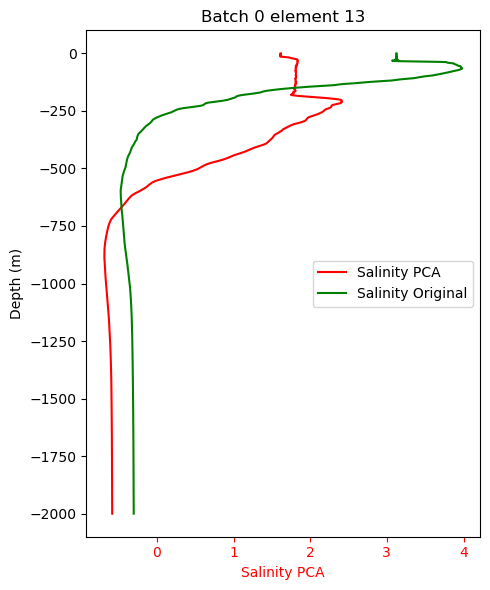

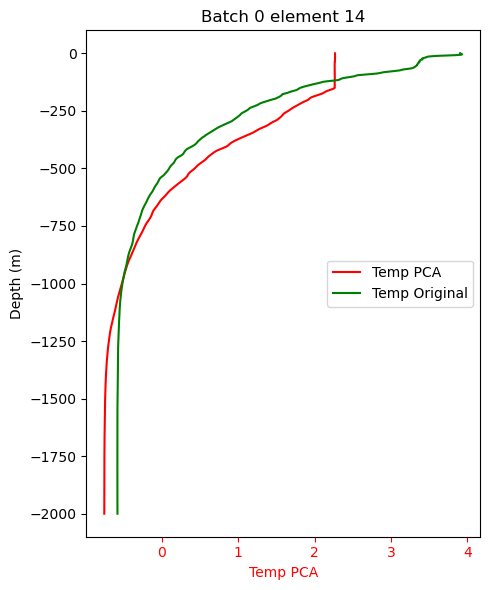

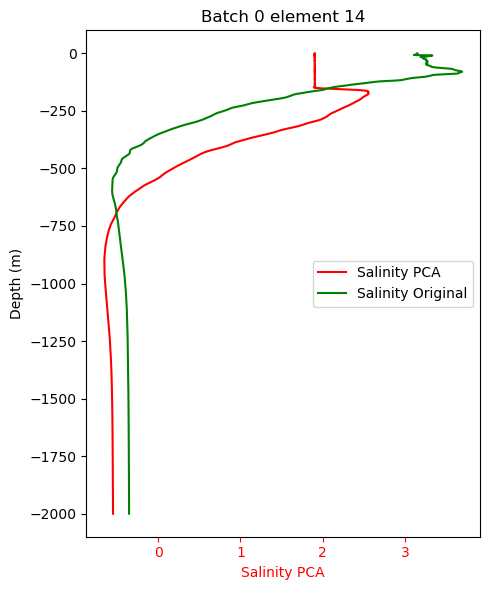

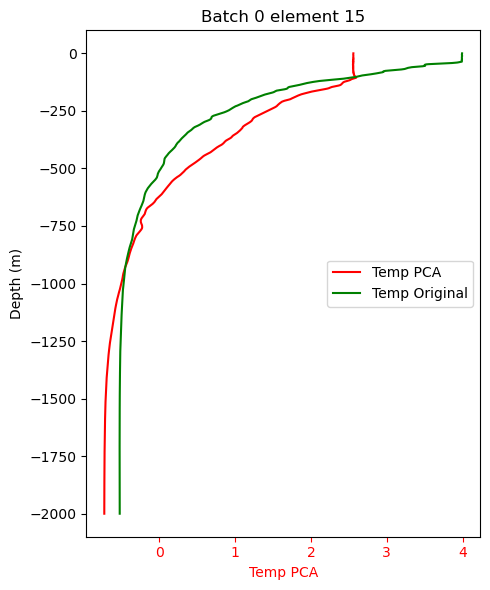

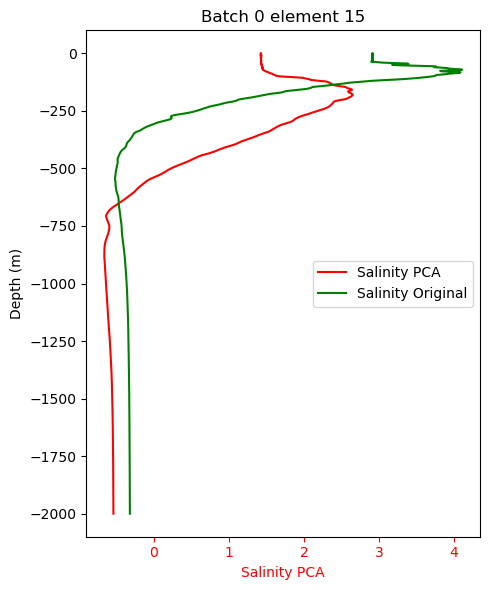

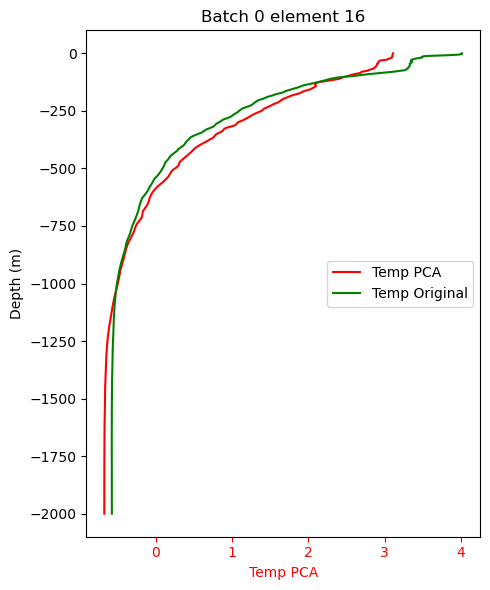

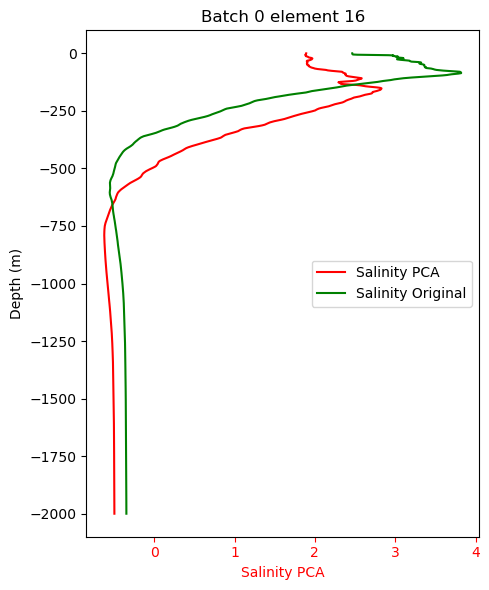

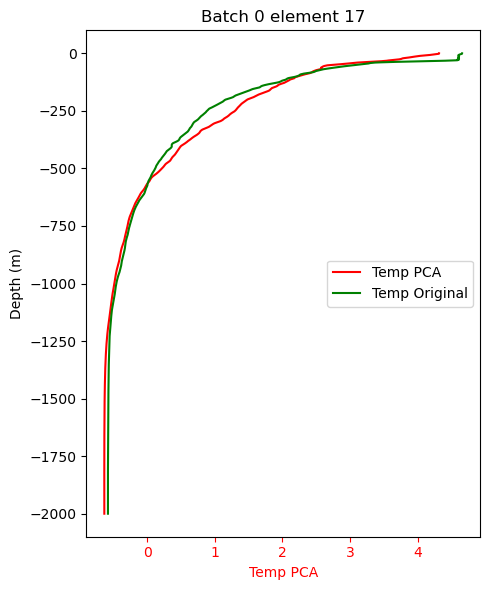

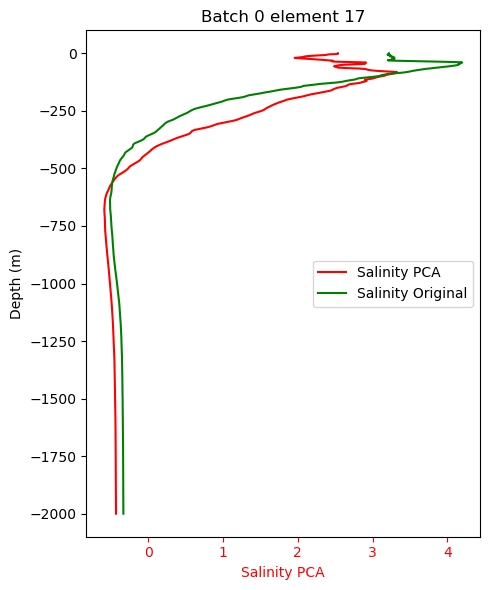

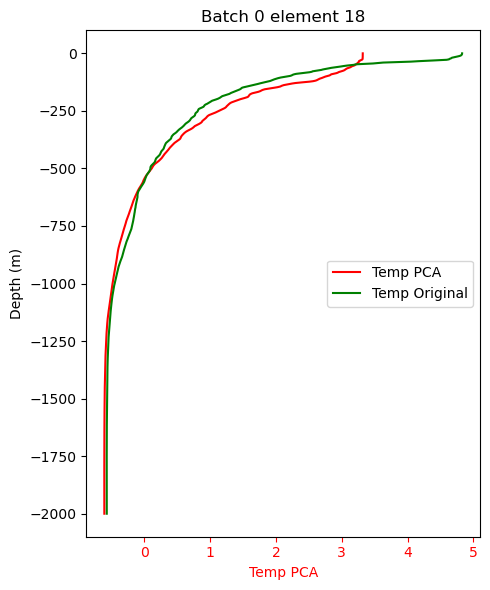

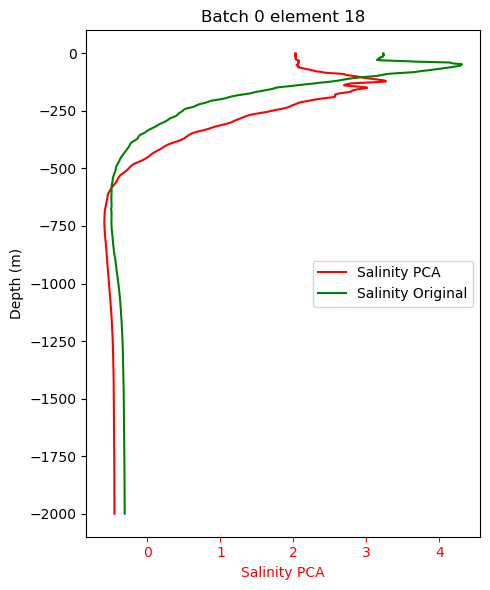

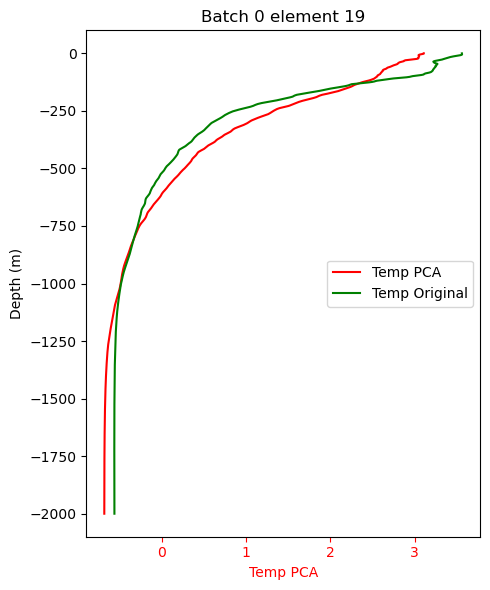

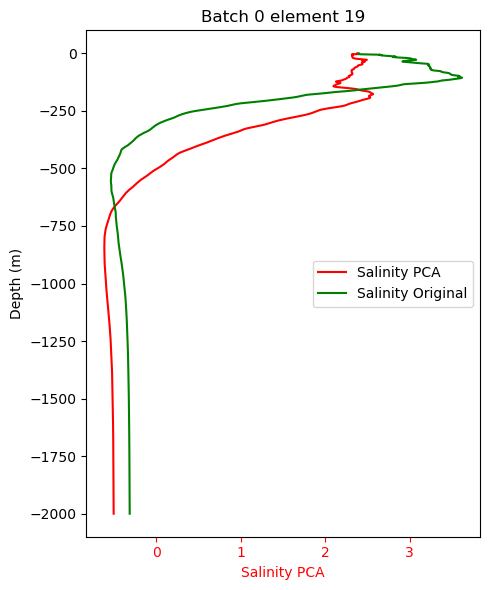

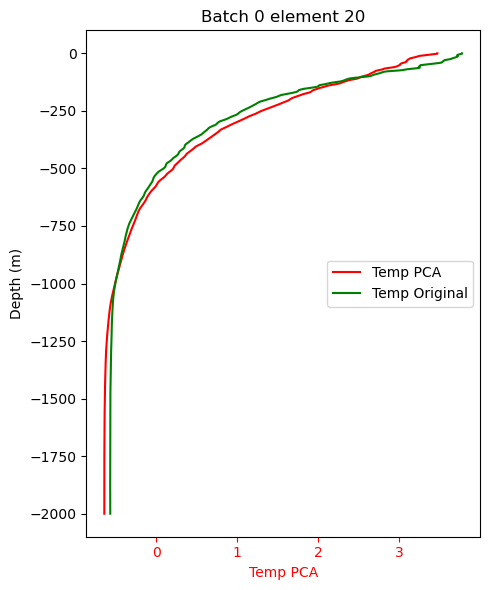

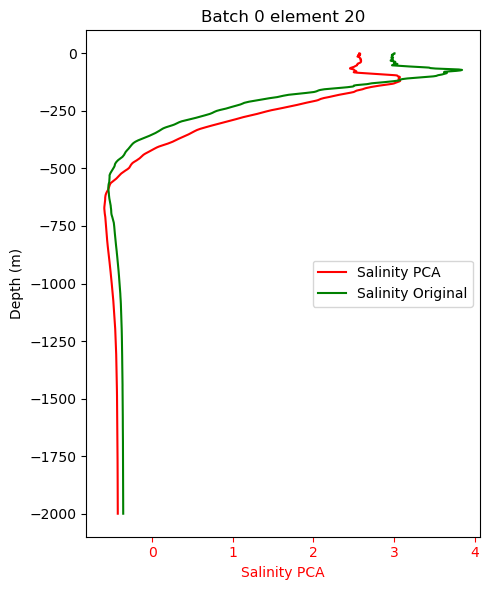

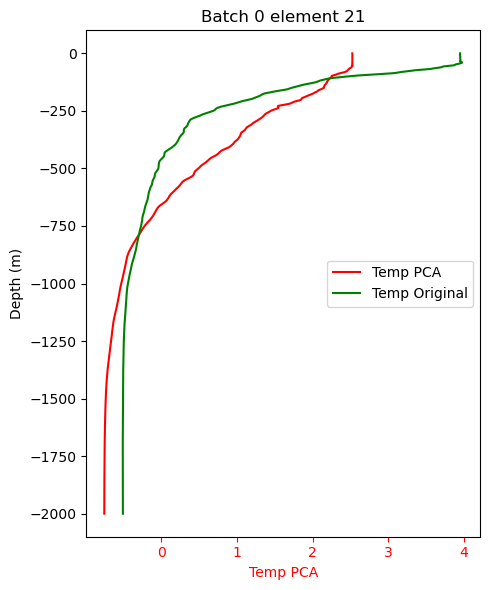

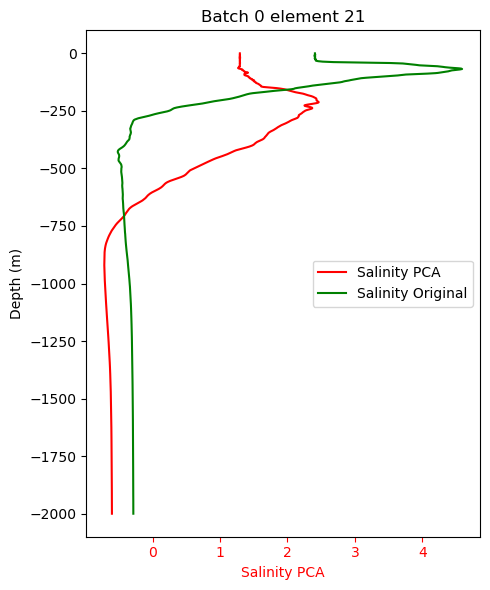

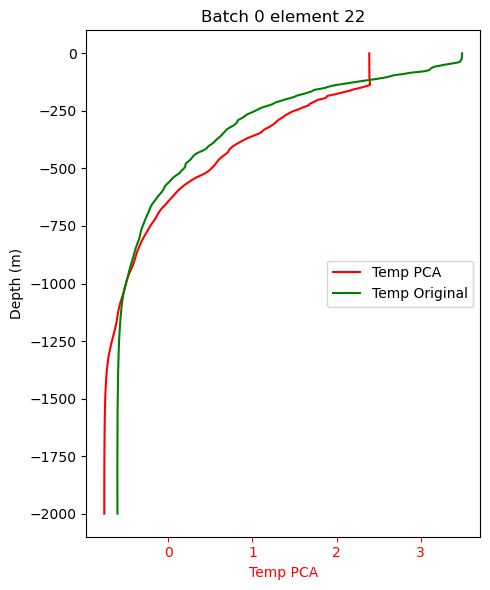

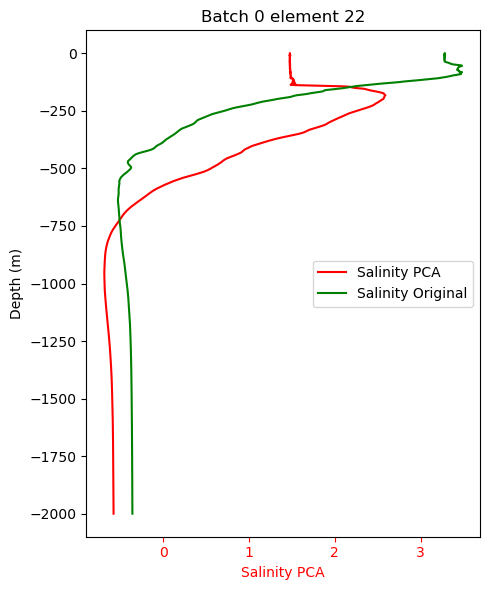

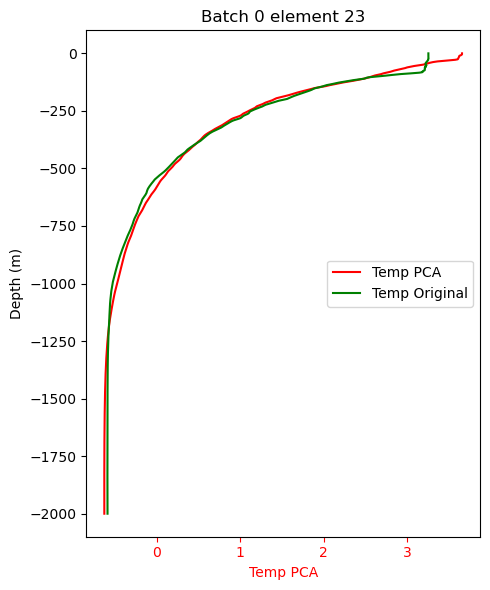

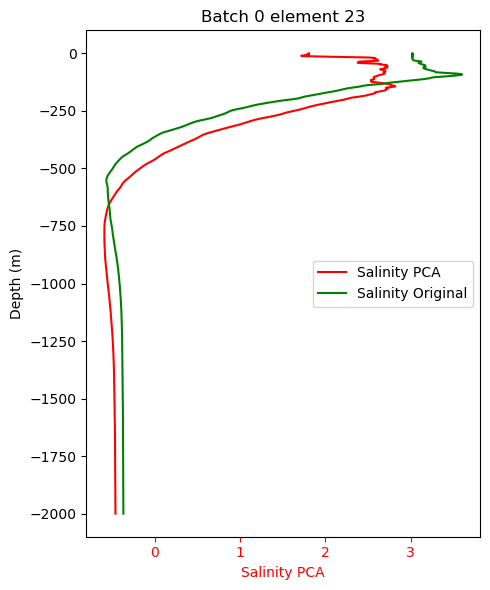

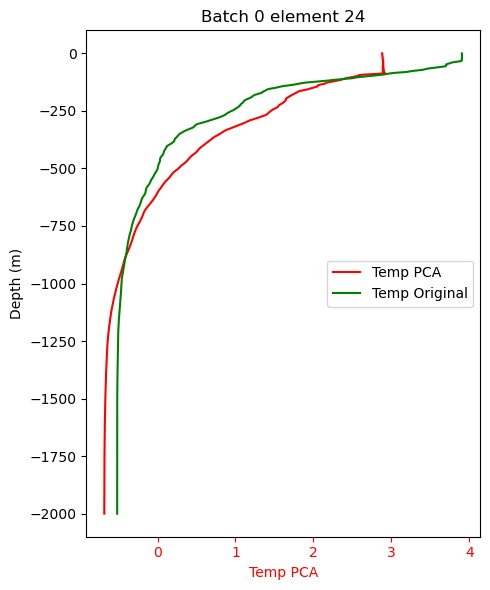

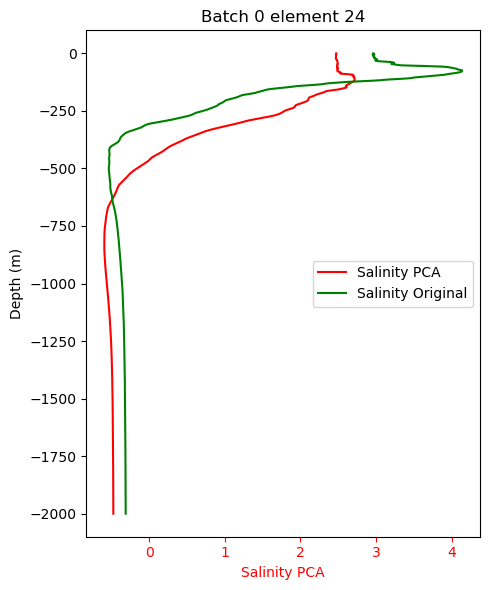

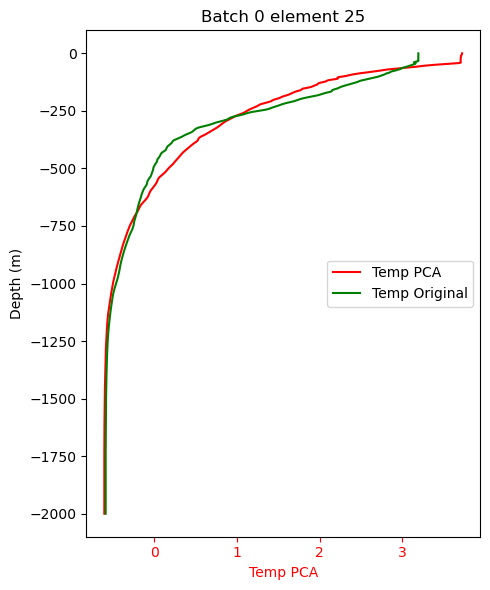

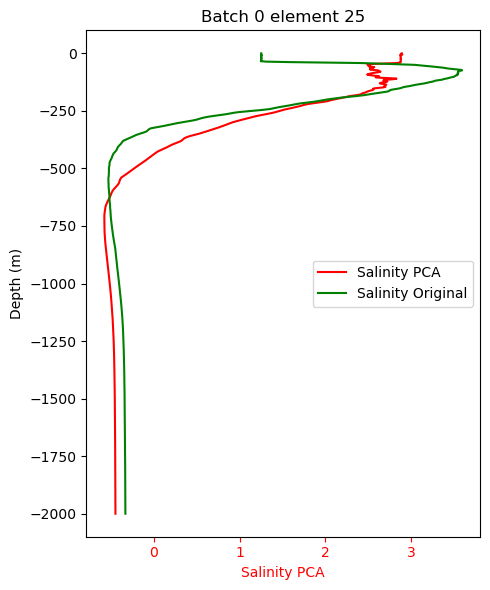

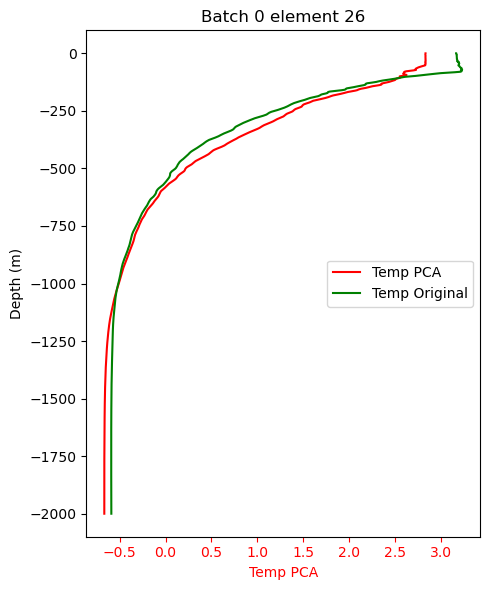

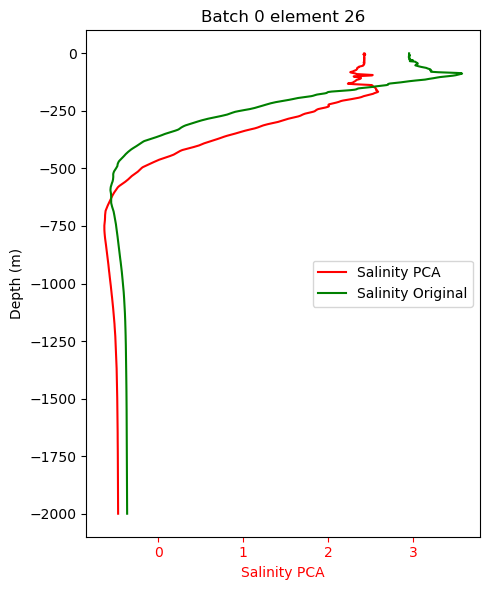

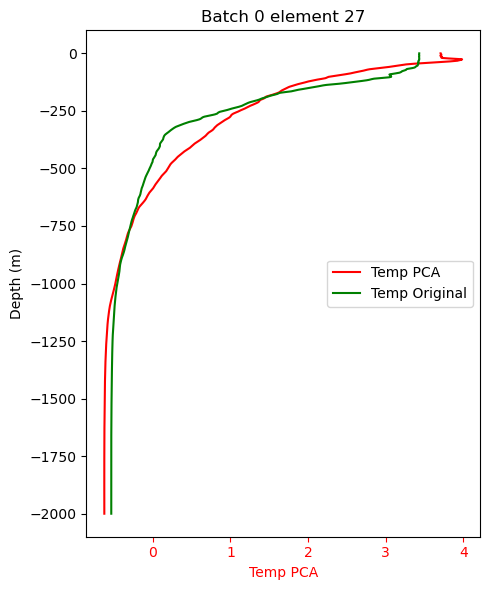

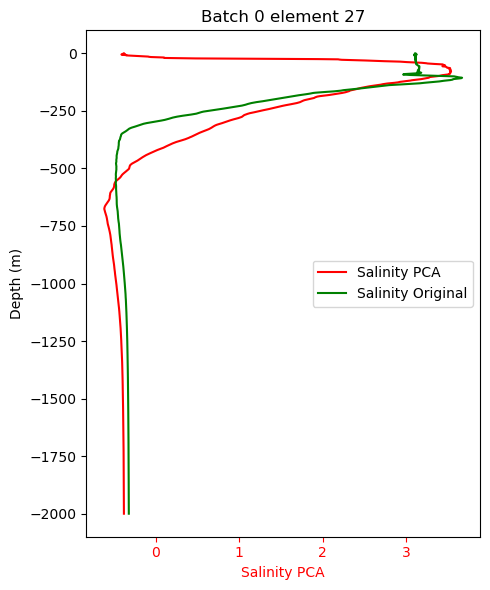

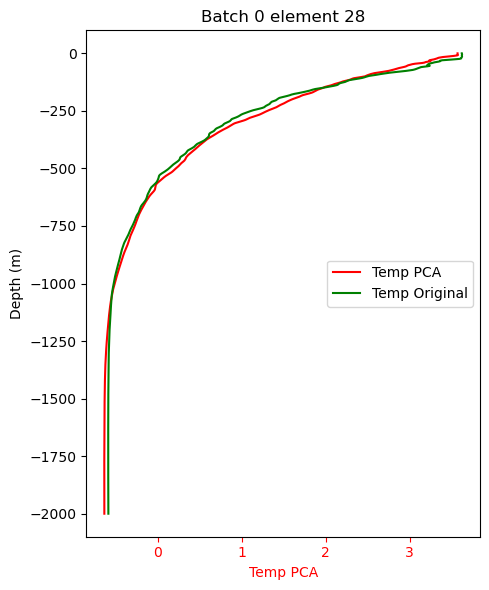

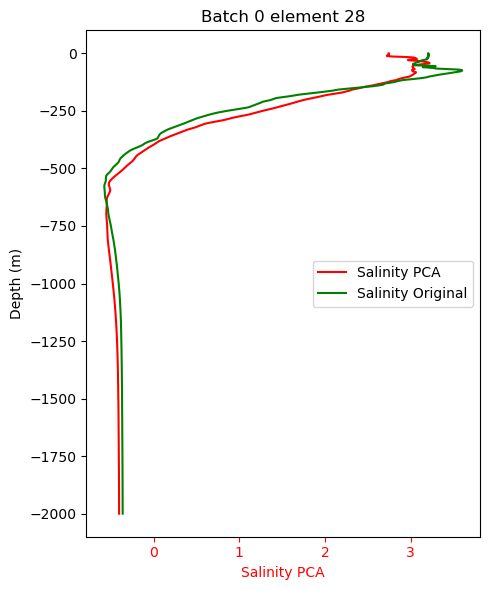

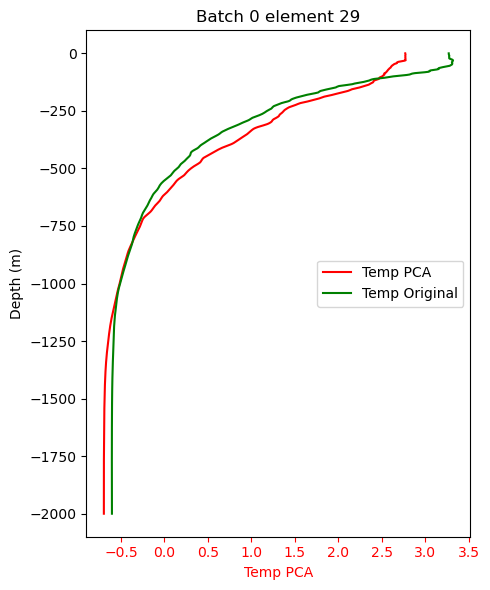

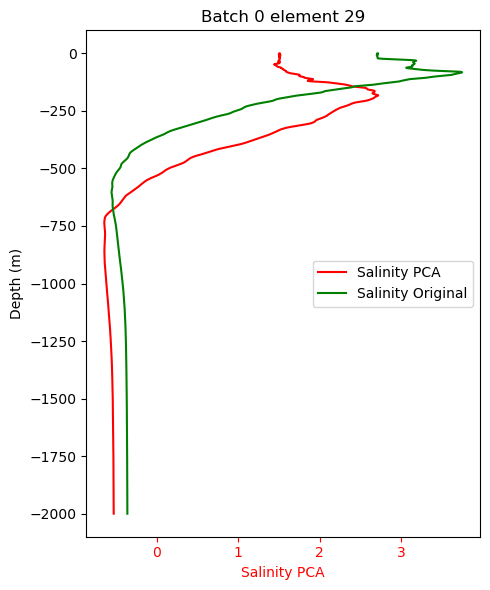

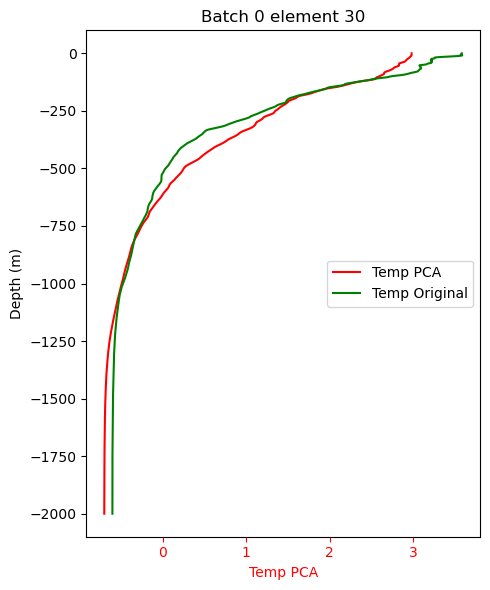

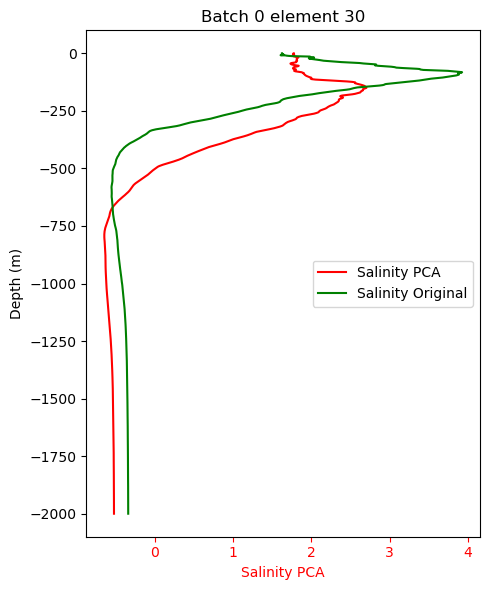

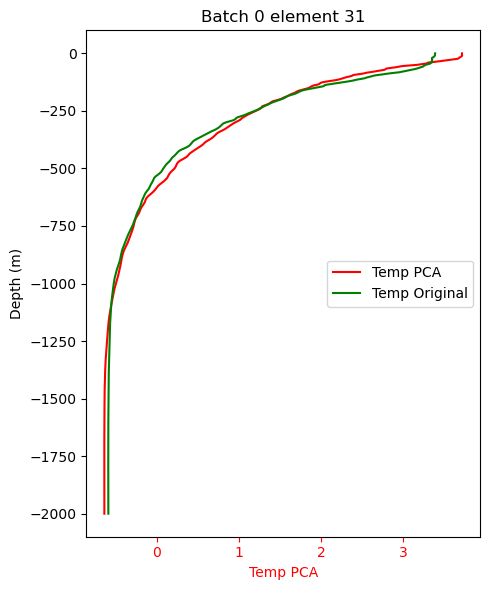

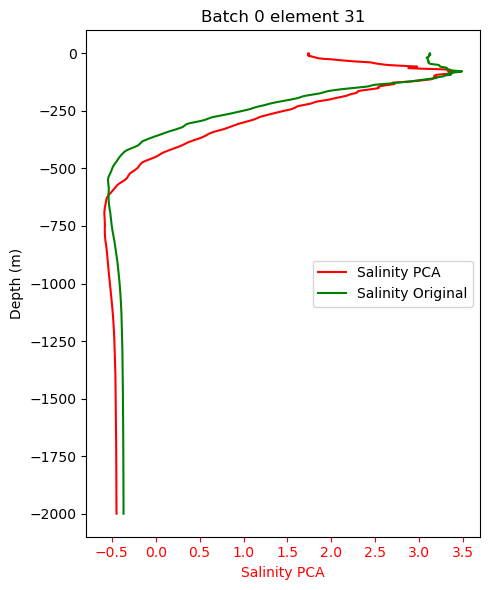

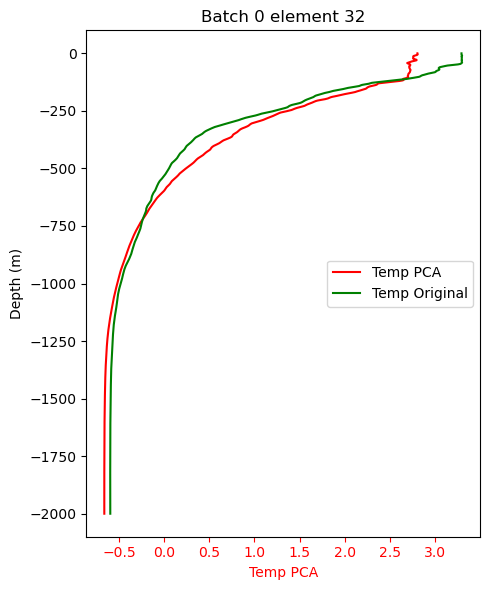

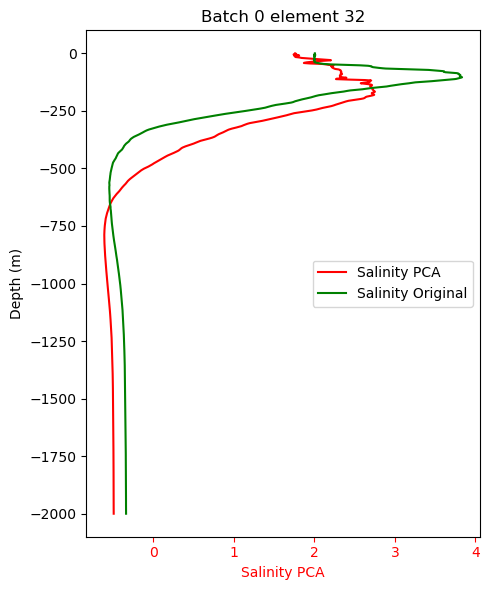

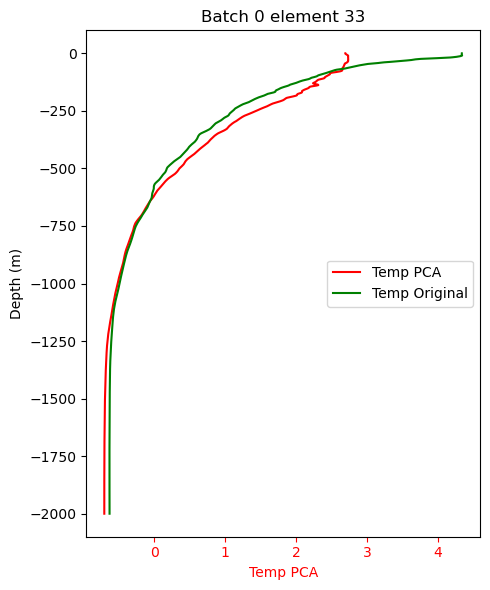

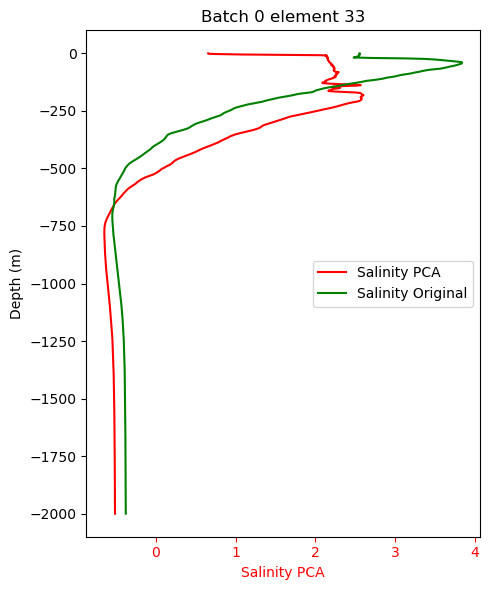

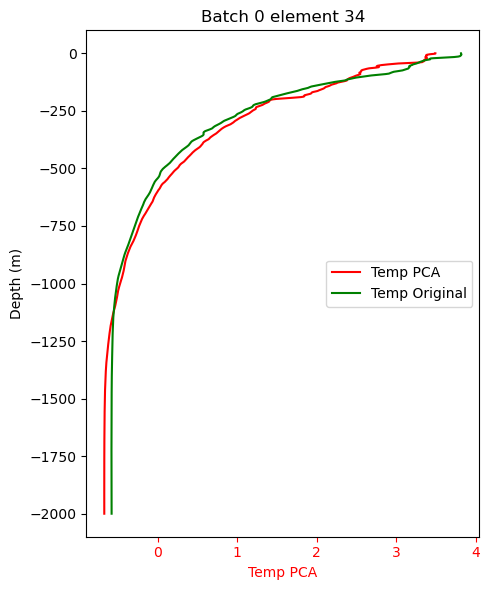

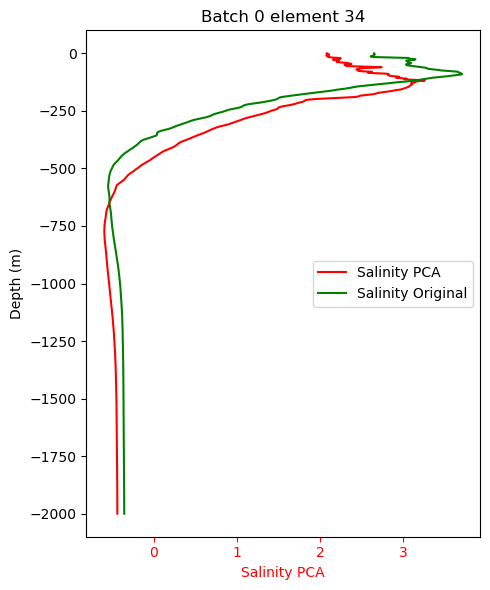

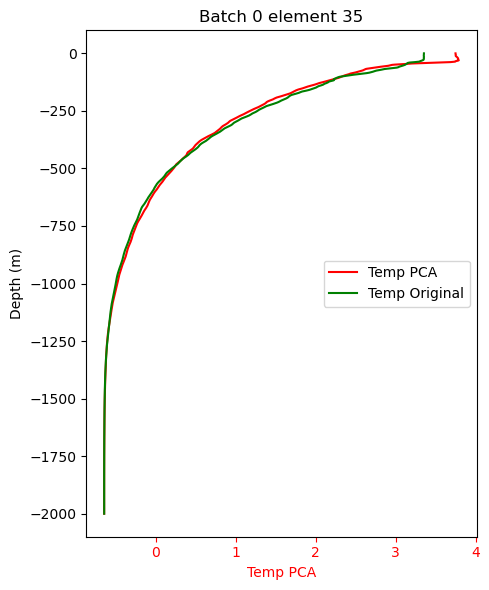

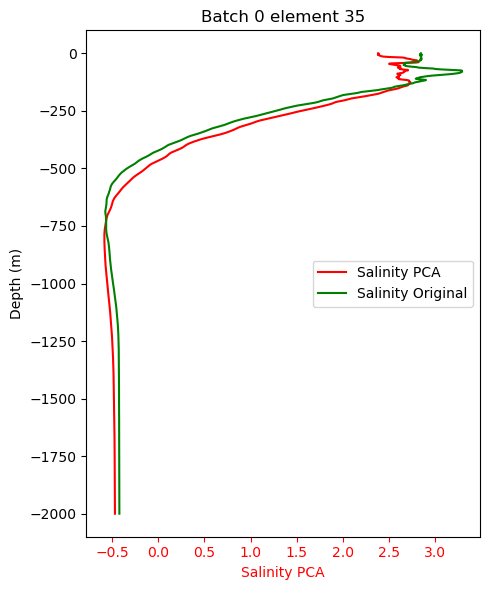

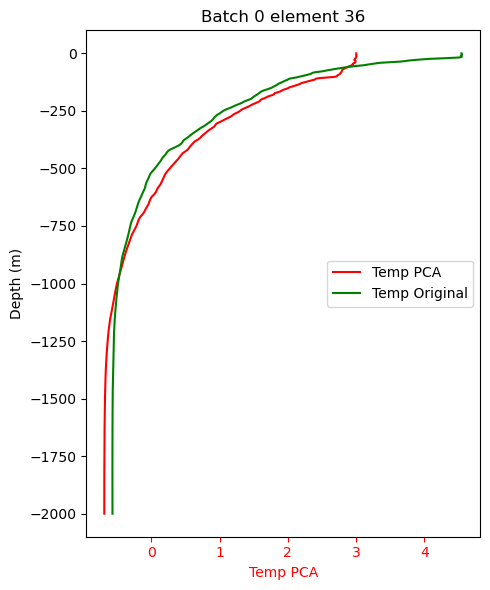

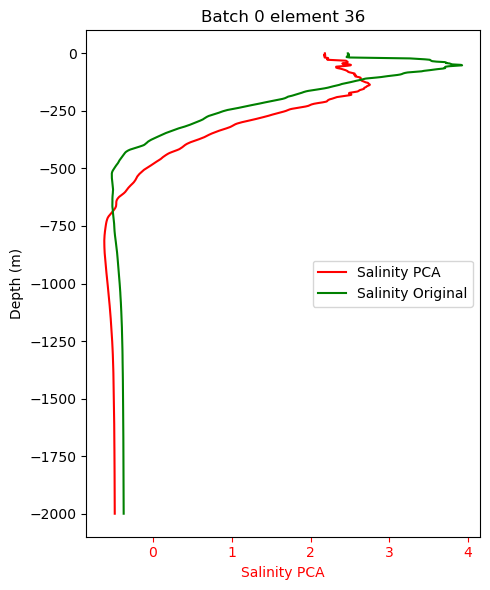

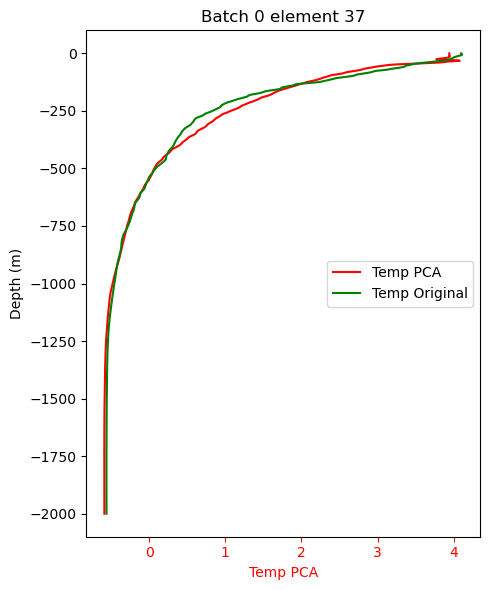

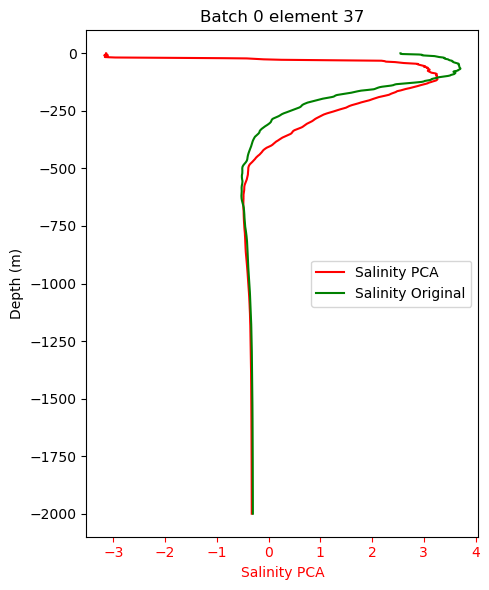

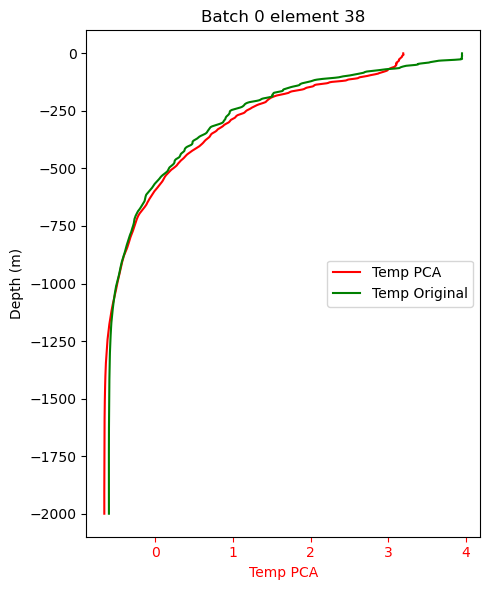

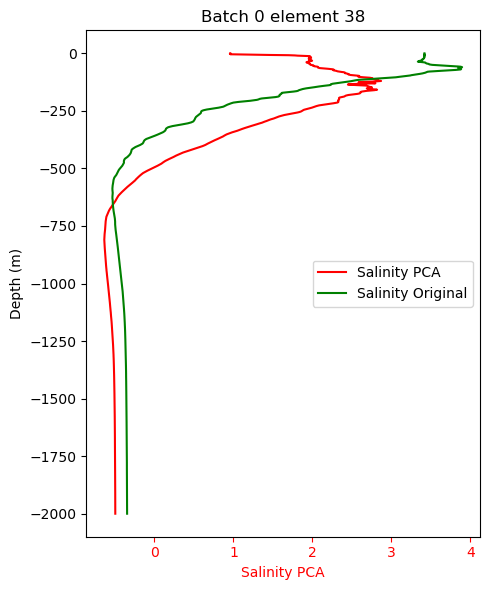

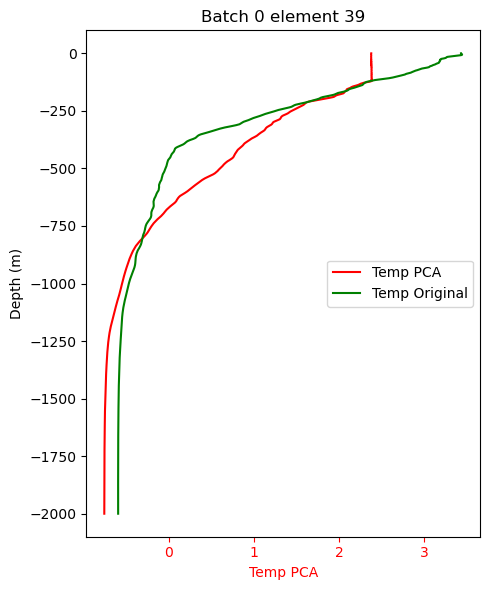

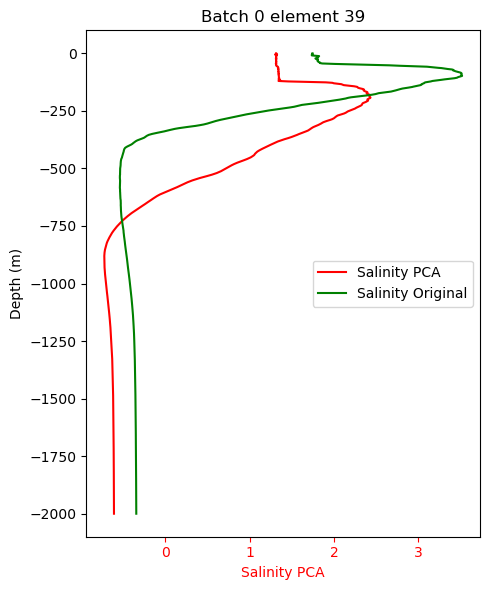

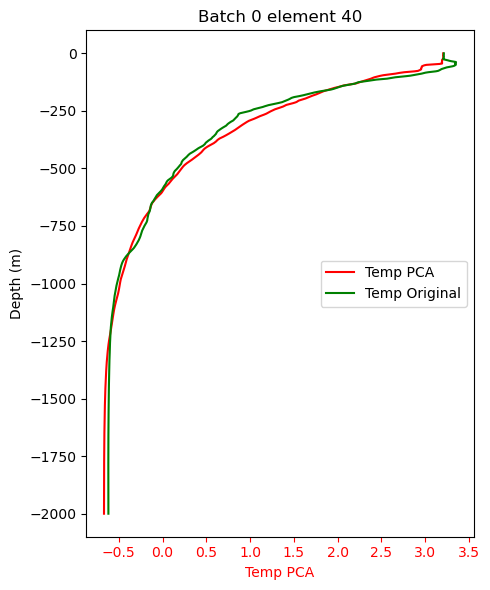

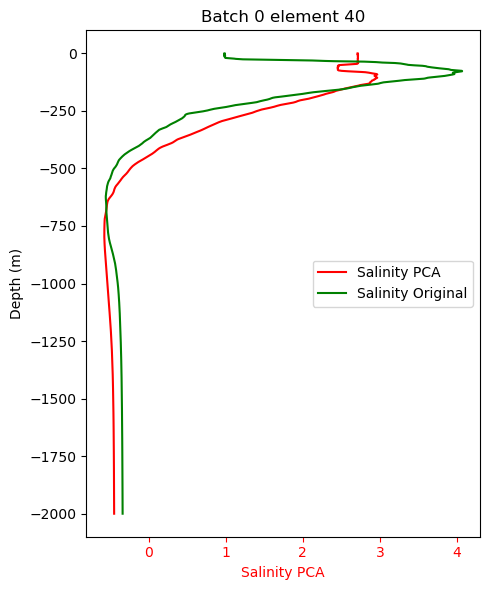

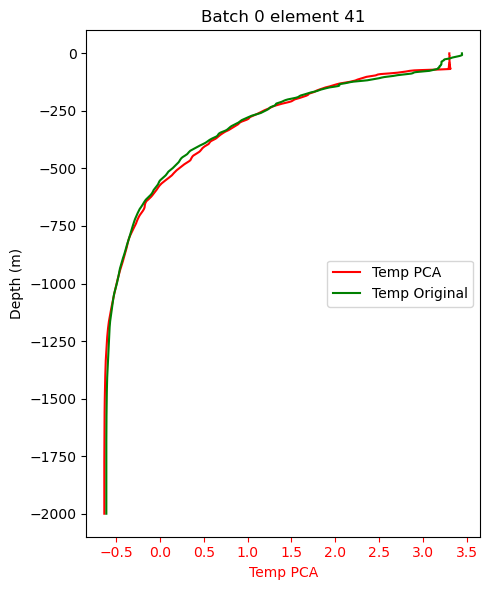

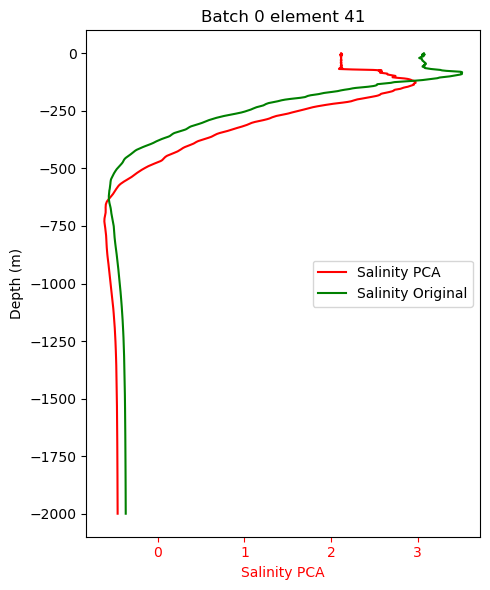

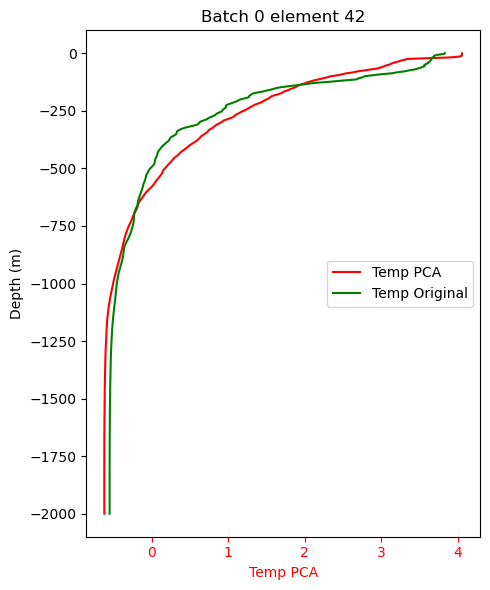

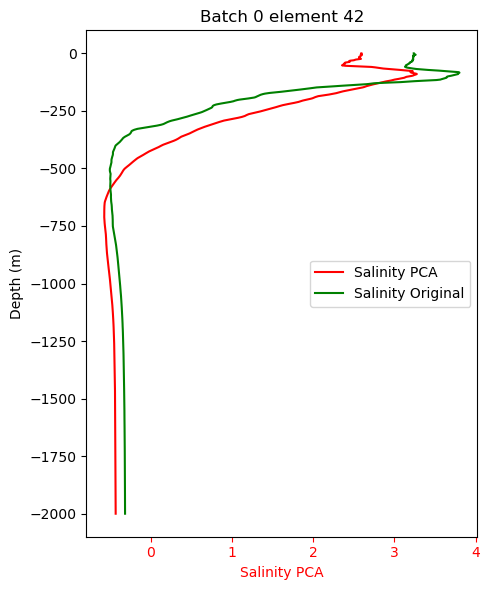

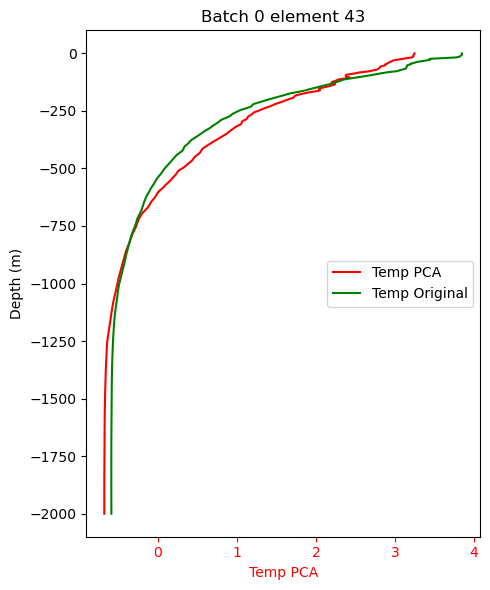

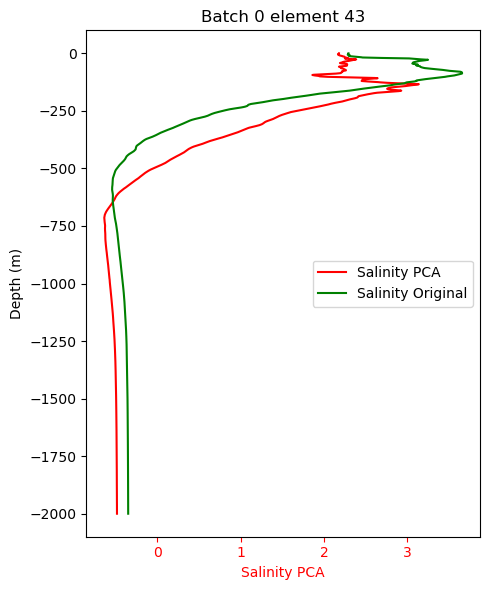

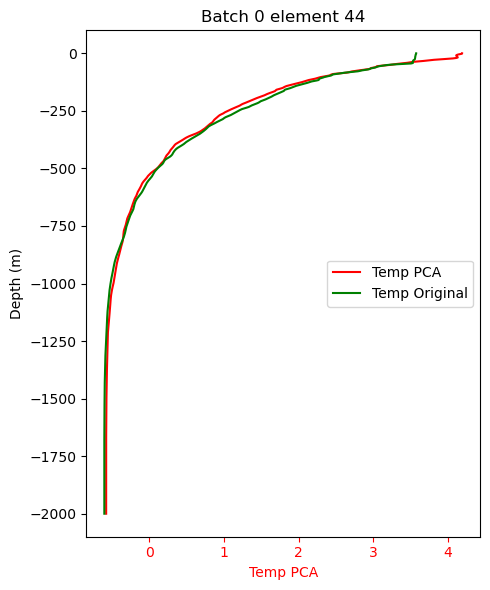

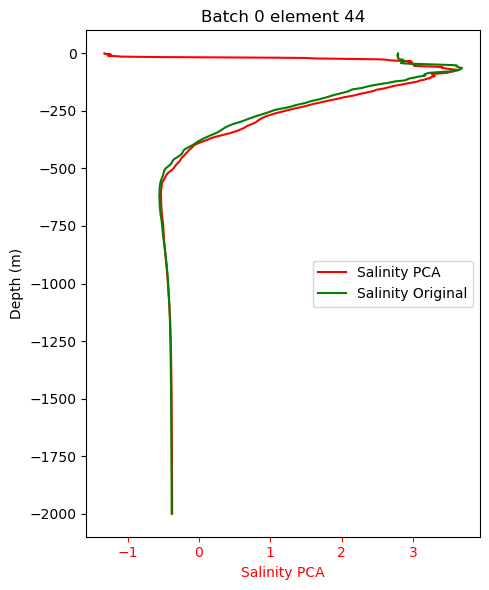

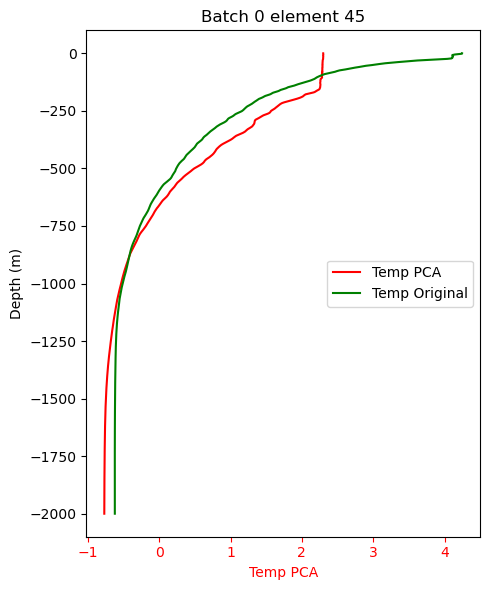

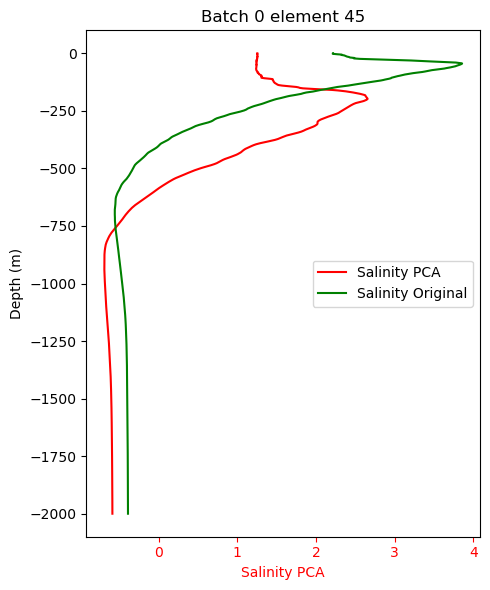

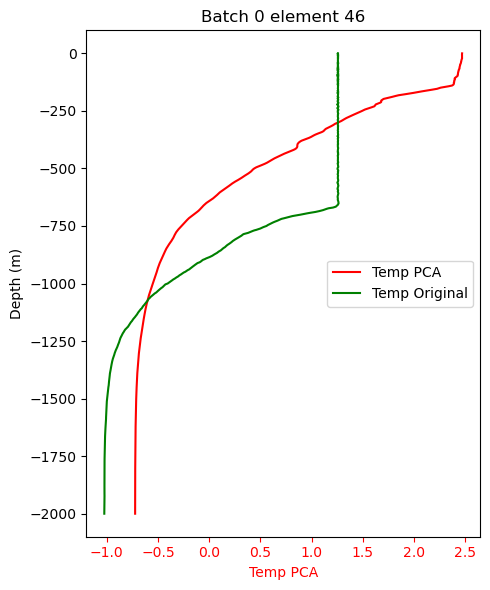

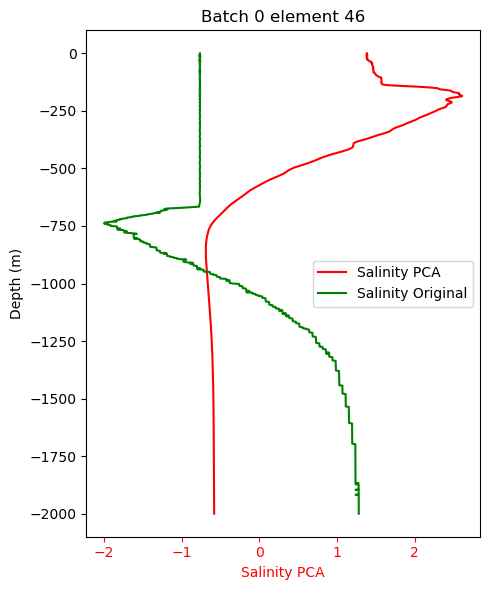

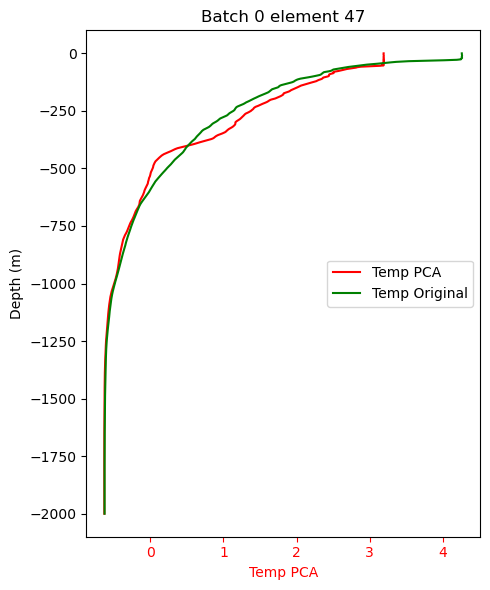

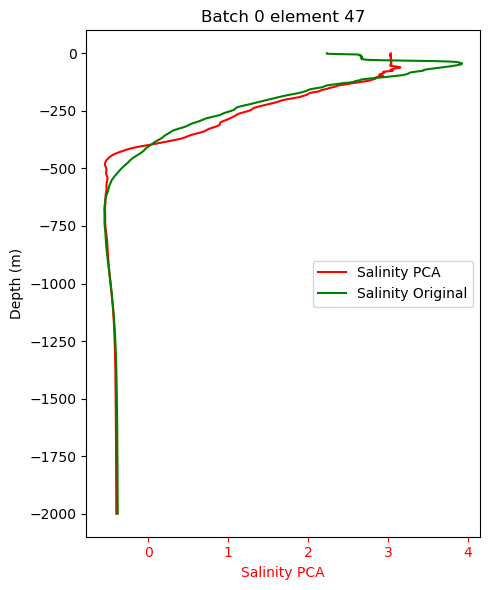

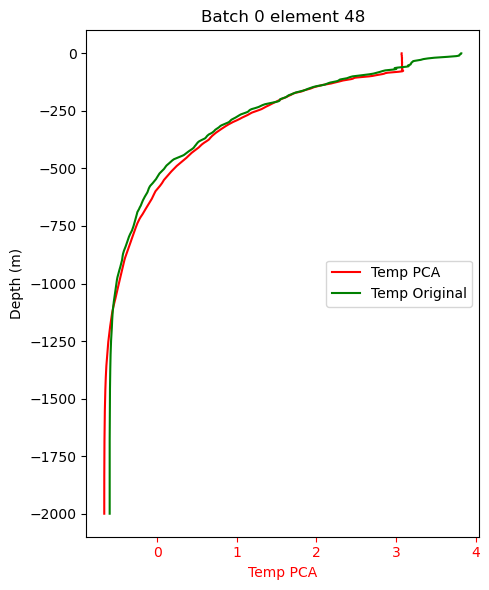

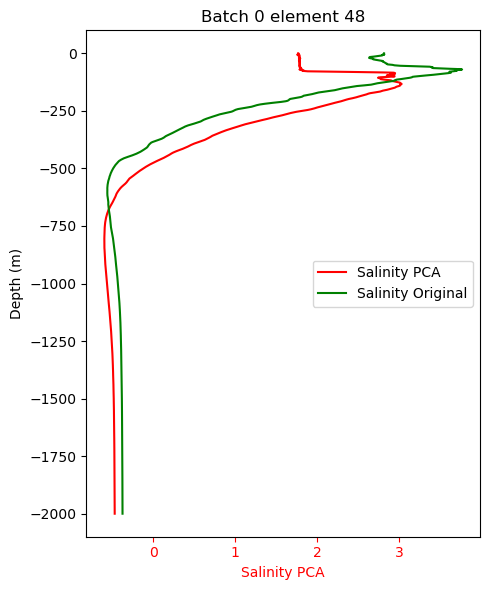

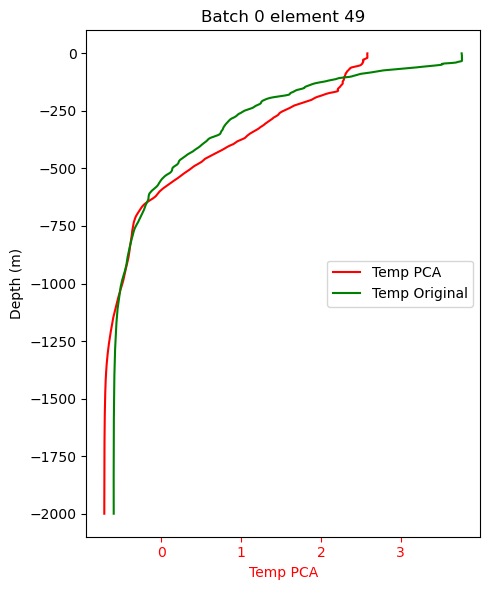

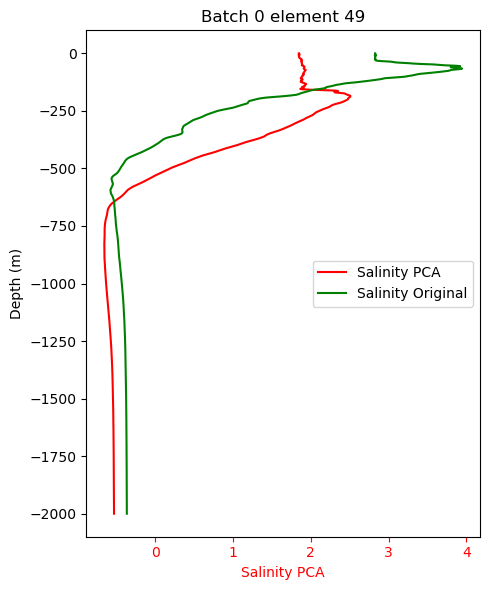

In [9]:
# dataset = revert_normalization(dataset, data_folder)
inoutdims = dataset.get_inout_dims()
for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(50):
    # for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

In [10]:
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_ai.Training import train_model
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data, revert_normalization, revert_normalization_prof

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
with_pca = True
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

Using device:  cuda


In [11]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

Temp PCA shape: (100, 4890), original shape: (100, 4890)
Explained Variance Ratio: 0.999637
Sal PCA shape: (100, 4890), original shape: (100, 4890)
Explained Variance Ratio: 0.999729


In [12]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

Total number of training samples:  4401
Total number of validation samples:  489
Done loading data!


In [13]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

Input Shape: torch.Size([400, 2])
Labels Shape: torch.Size([400, 200])


In [14]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 50
neurons_per_layer = 100
# activation_hidden =  # tanh, sigmoid # 'relu'
# activation_hidden = 'sigmoid' #best for NoPCA
activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

DenseModel: hidden_layers:50, neurons_per_layer:100, activation_hidden:relu, activation_output:linear


In [15]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

Training model...


/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/proj_ai/proj_models.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.batch_nomalization and l1.shape[0] > 1:


Epoch: 1, Val loss: 0.001728 Training loss: 0.0030
Epoch: 2, Val loss: 0.001730 Training loss: 0.0024
Epoch: 3, Val loss: 0.001740 Training loss: 0.0027
Epoch: 4, Val loss: 0.001744 Training loss: 0.0024
Epoch: 5, Val loss: 0.001723 Training loss: 0.0023
Epoch: 6, Val loss: 0.001736 Training loss: 0.0021
Epoch: 7, Val loss: 0.001708 Training loss: 0.0021
Epoch: 8, Val loss: 0.001711 Training loss: 0.0021
Epoch: 9, Val loss: 0.001695 Training loss: 0.0021
Epoch: 10, Val loss: 0.001801 Training loss: 0.0021
Epoch: 11, Val loss: 0.001684 Training loss: 0.0020
Epoch: 12, Val loss: 0.001723 Training loss: 0.0020
Epoch: 13, Val loss: 0.001728 Training loss: 0.0020
Epoch: 14, Val loss: 0.001636 Training loss: 0.0024
Epoch: 15, Val loss: 0.001727 Training loss: 0.0024
Epoch: 16, Val loss: 0.001506 Training loss: 0.0019
Epoch: 17, Val loss: 0.001329 Training loss: 0.0023
Epoch: 18, Val loss: 0.001460 Training loss: 0.0017
Epoch: 19, Val loss: 0.001445 Training loss: 0.0012
Epoch: 20, Val loss: 

In [16]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

In [17]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    predictions = model(inputs.to(device))
    print("Predictions Shape:", predictions.shape)

# Comparing prediction to actual label for the first data point and save
plt.figure()
plt.plot(predictions[0].cpu().numpy(), label="Prediction", linewidth=0.3, color="red")
plt.plot(labels[0].numpy(), label="Ground Truth", linewidth=0.3, color="blue")
plt.legend()
plt.grid()
plt.title("Prediction VS Ground Truth - First case - " + model_name)
plt.savefig('comparison_' + model_name+ '.png', dpi=600)
plt.close()

Predictions Shape: torch.Size([400, 200])


Batch size: 400, Input size: torch.Size([489, 2]), Output size: torch.Size([489, 200])


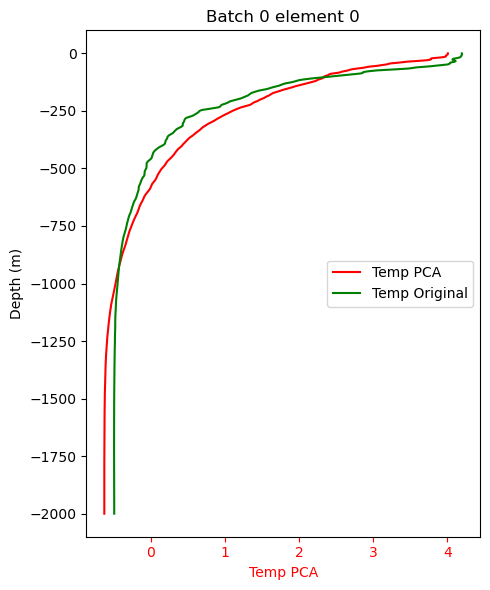

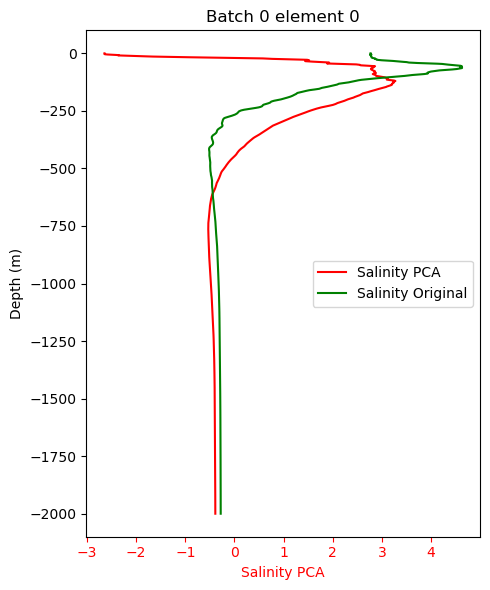

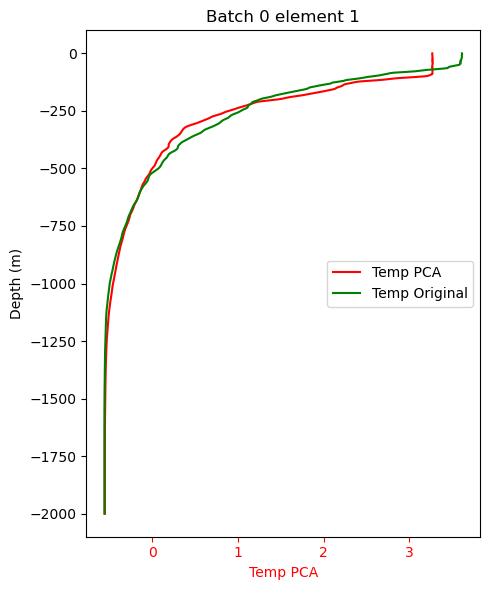

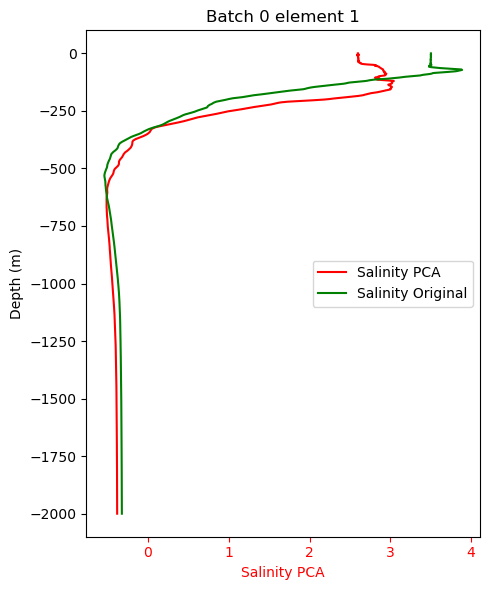

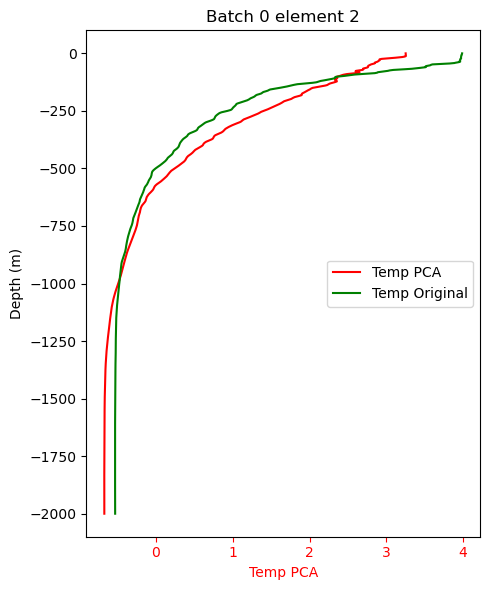

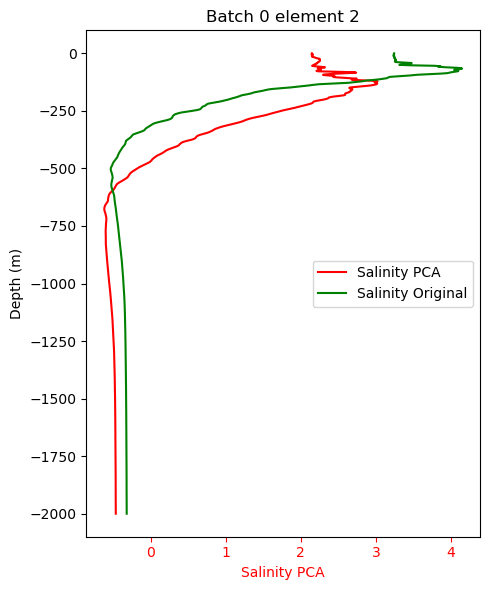

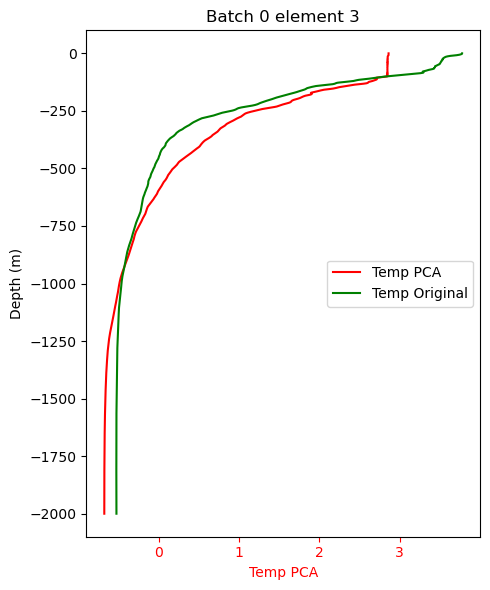

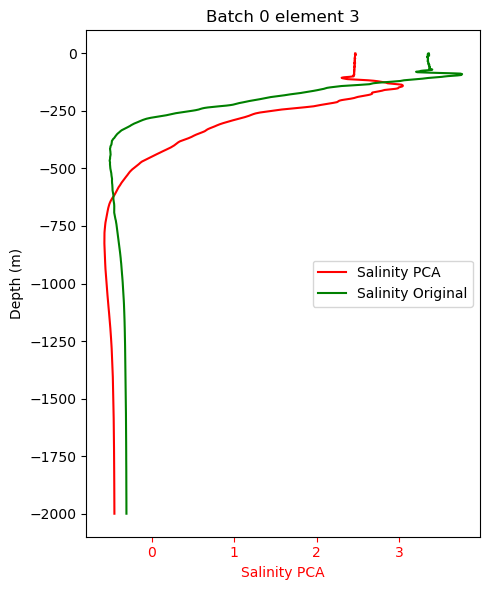

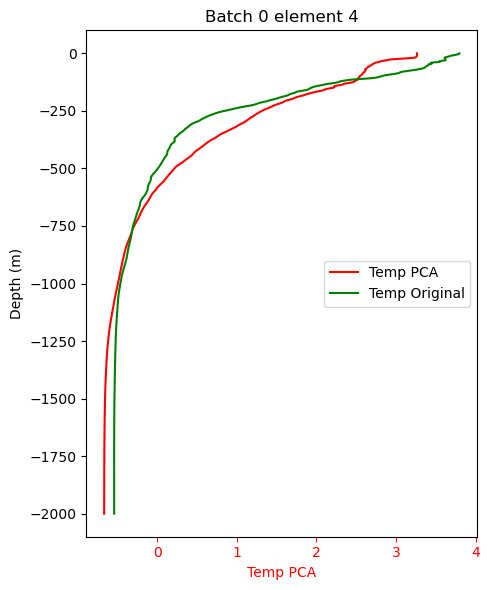

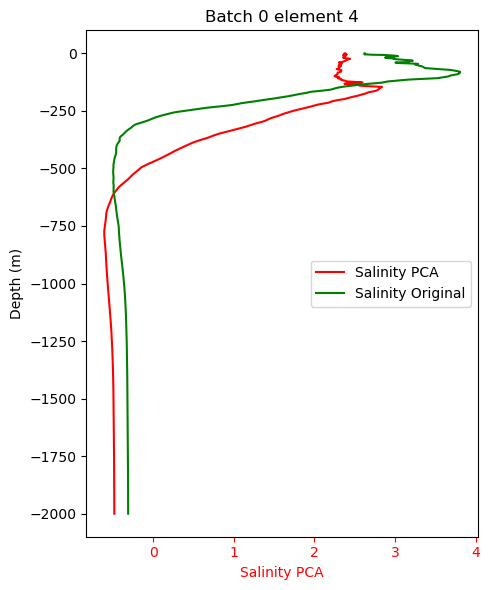

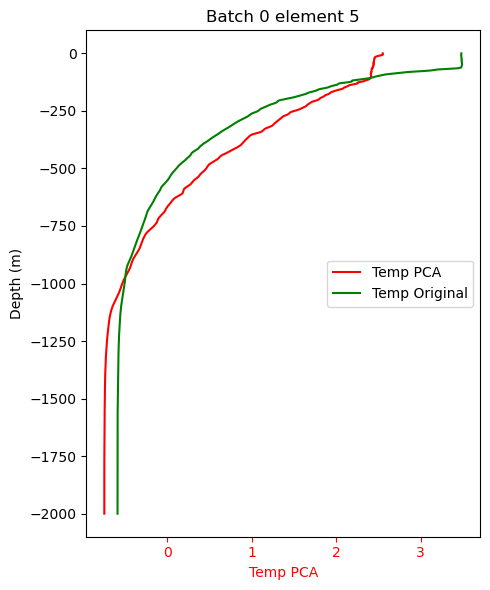

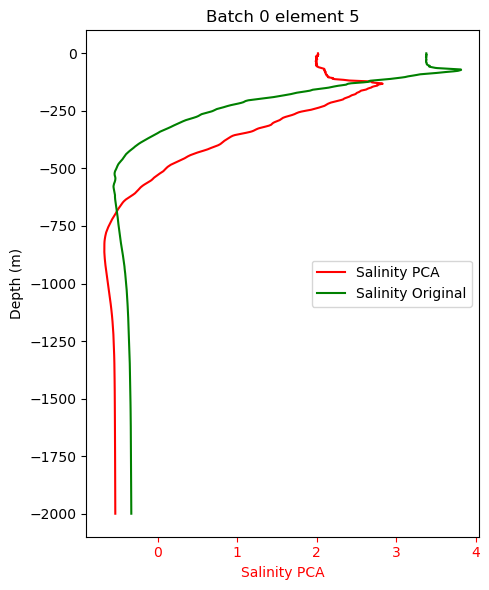

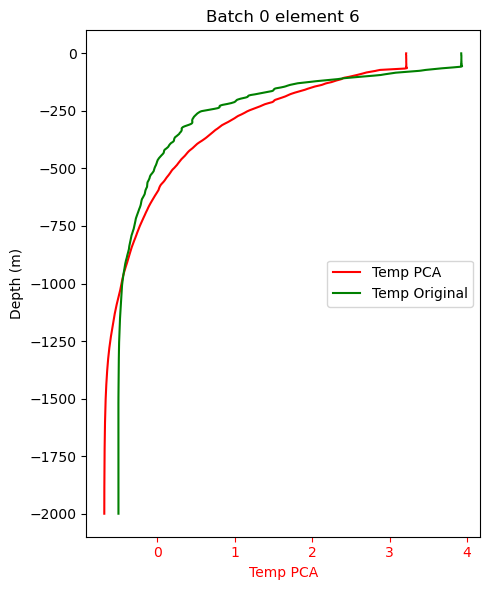

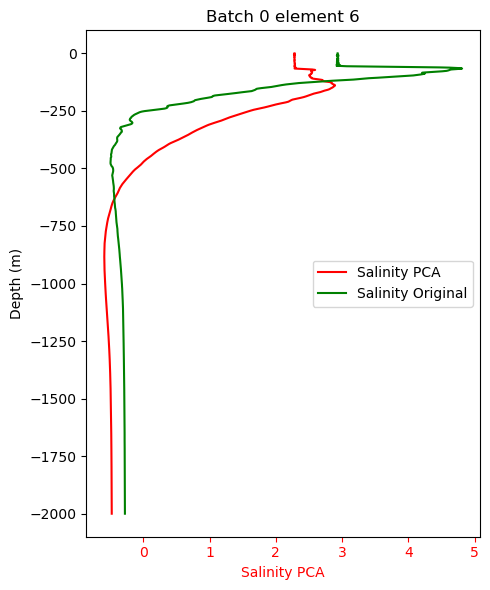

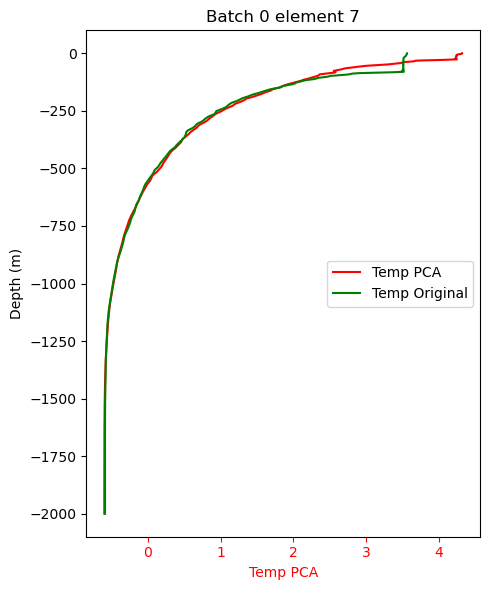

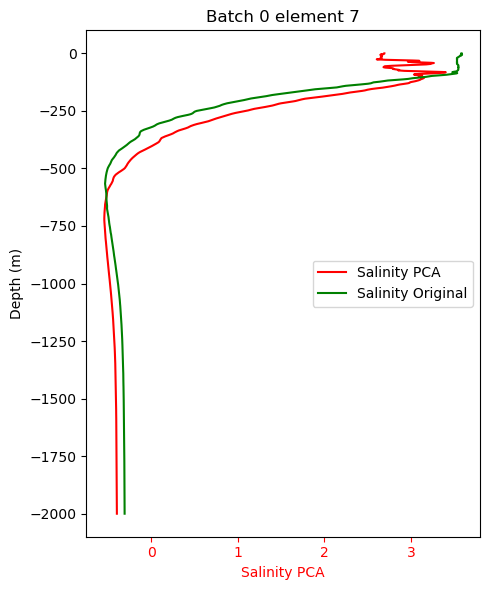

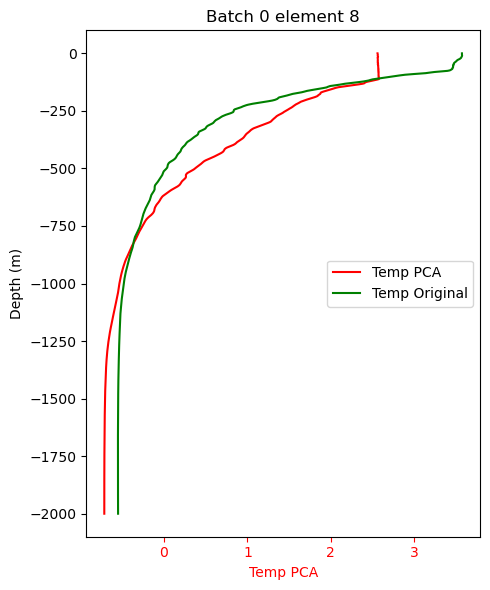

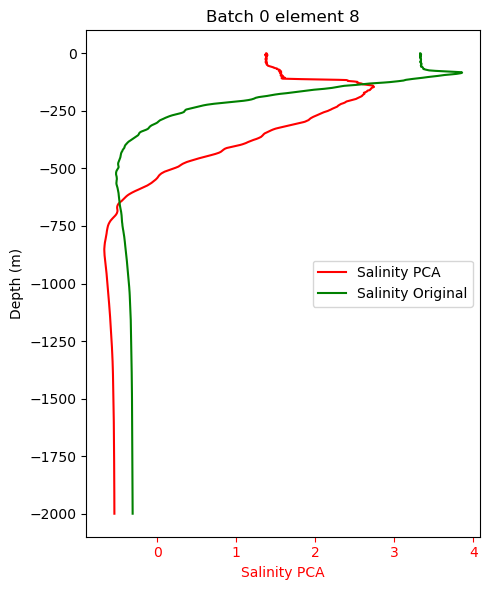

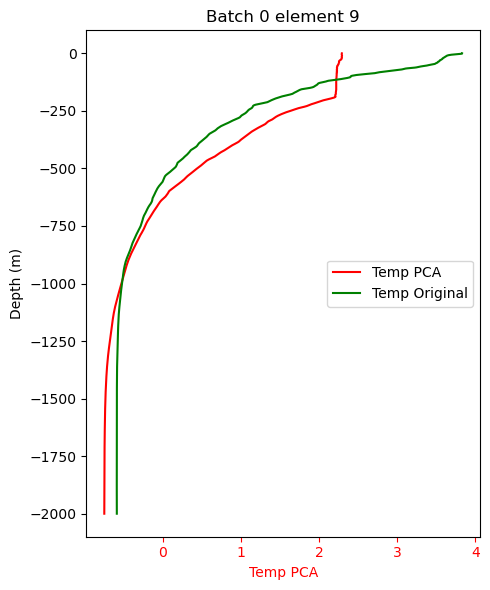

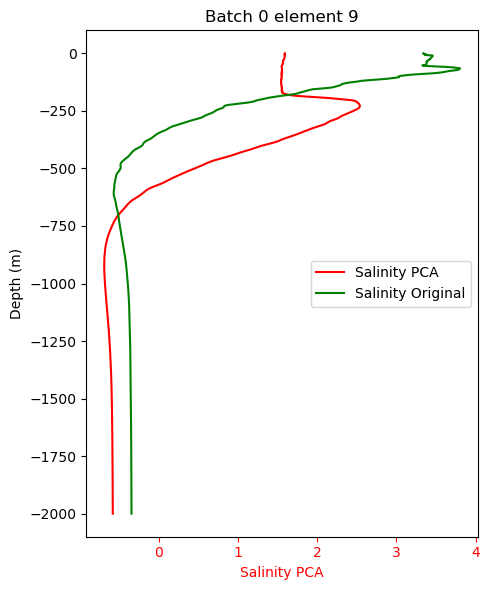

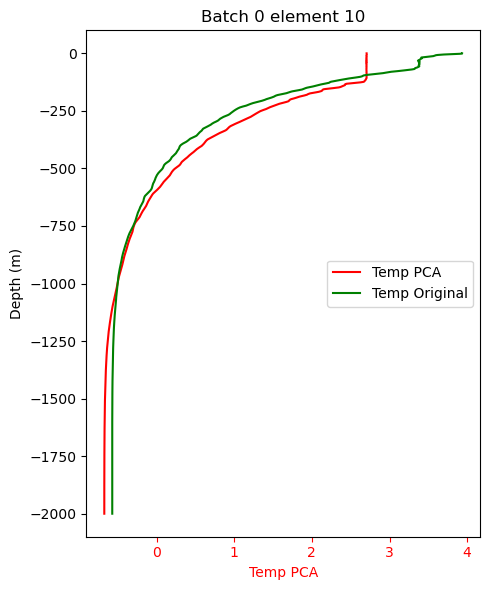

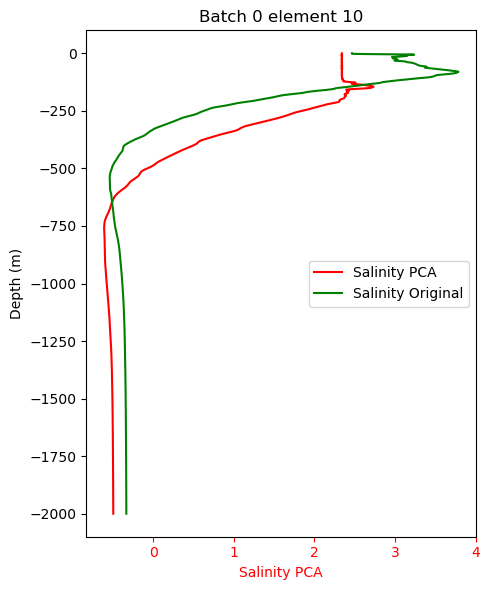

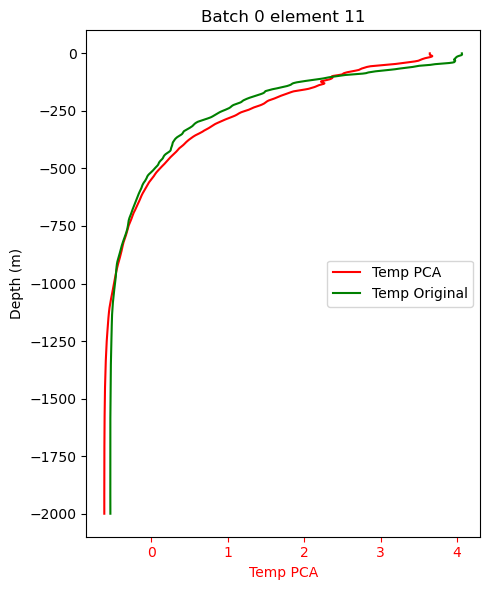

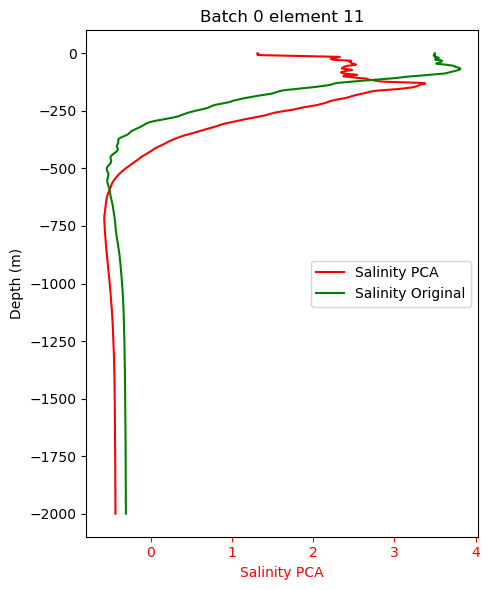

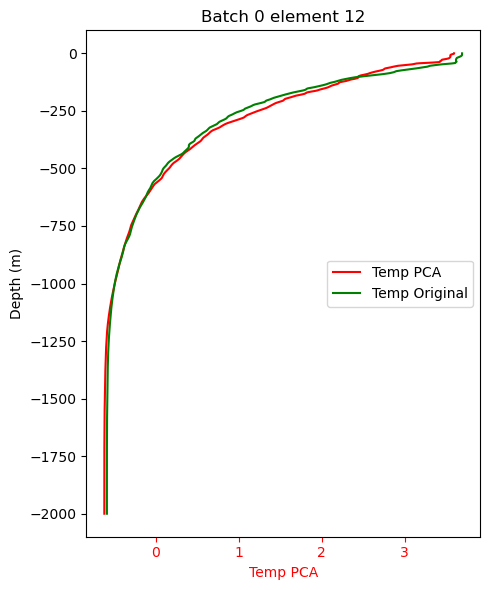

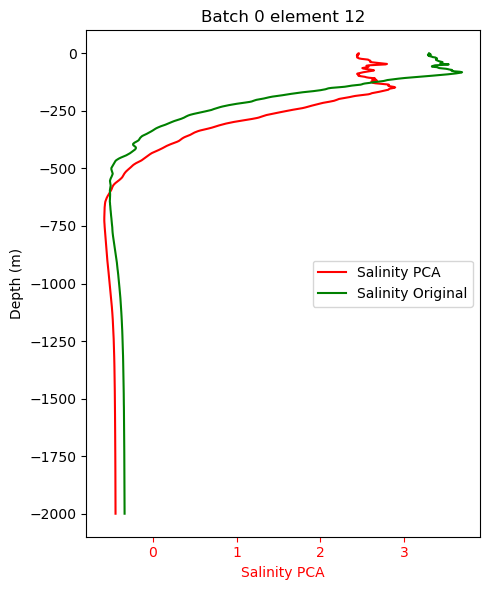

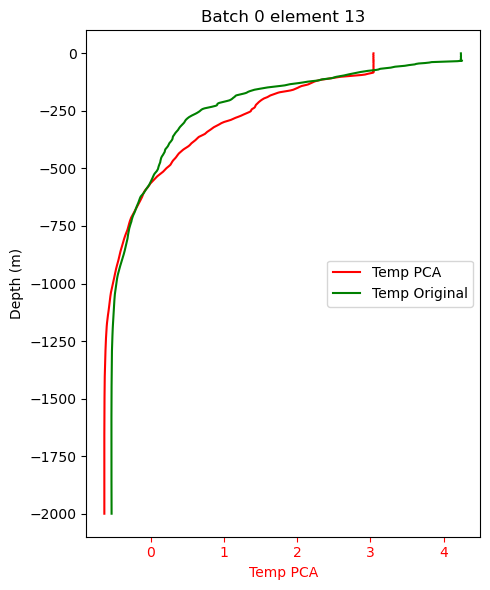

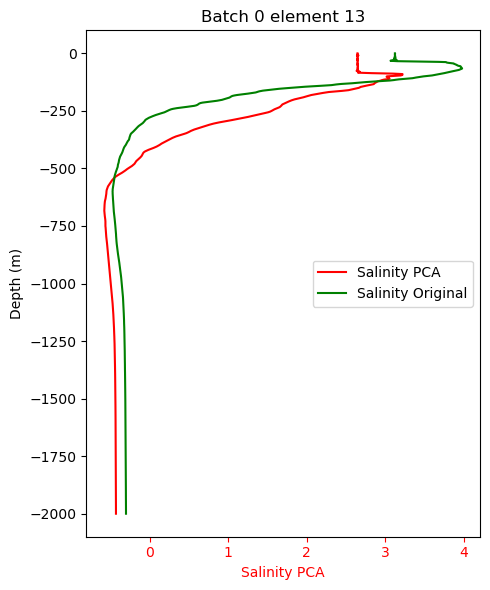

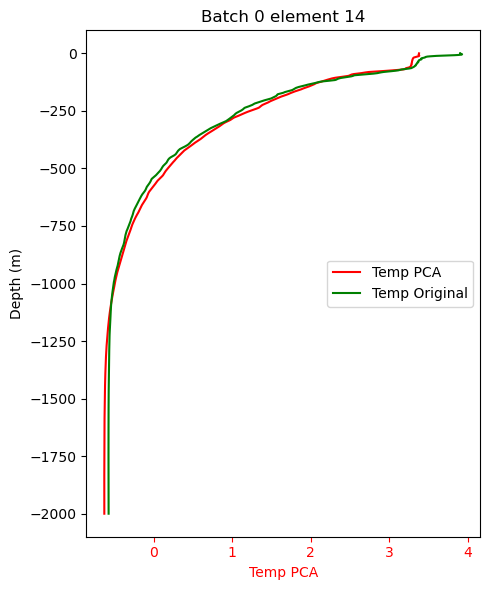

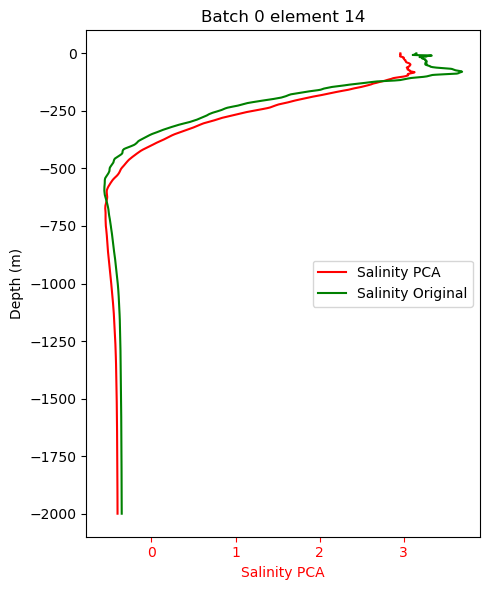

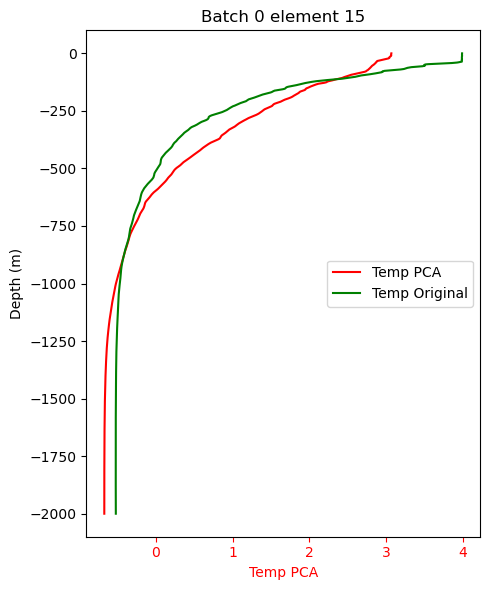

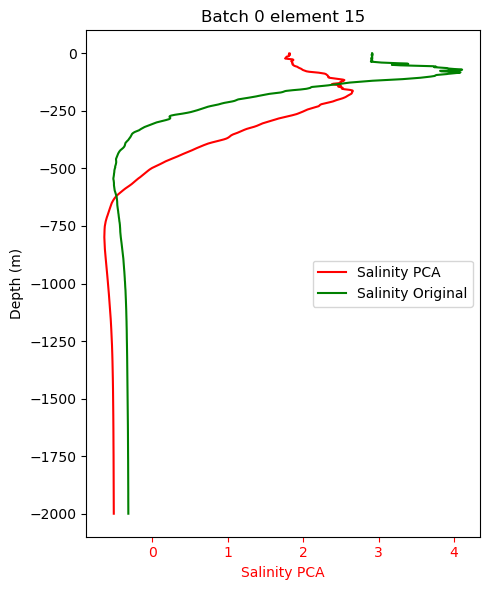

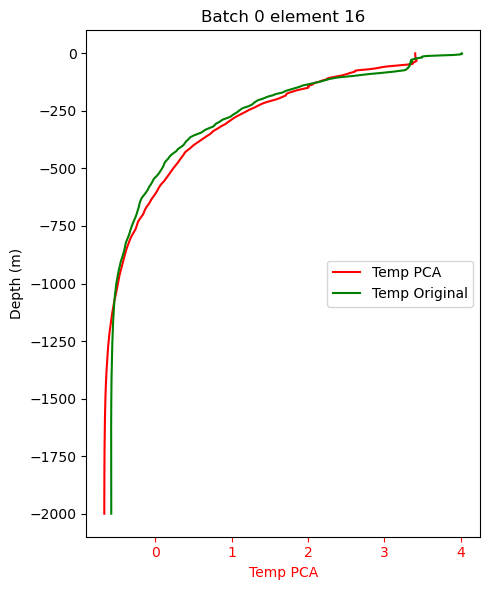

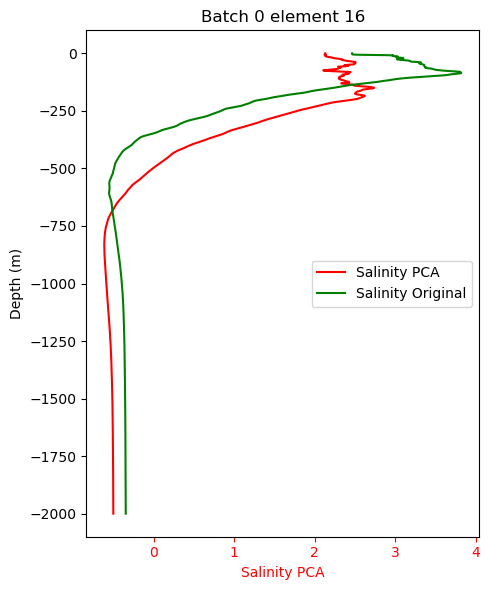

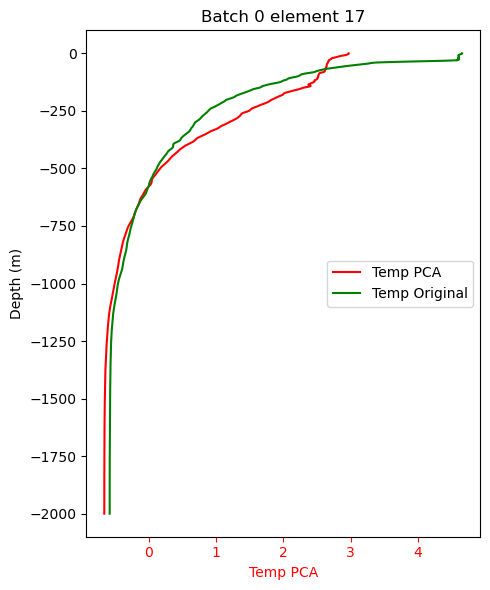

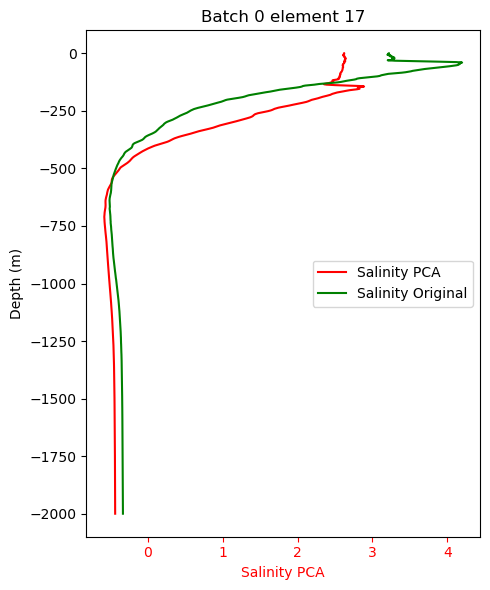

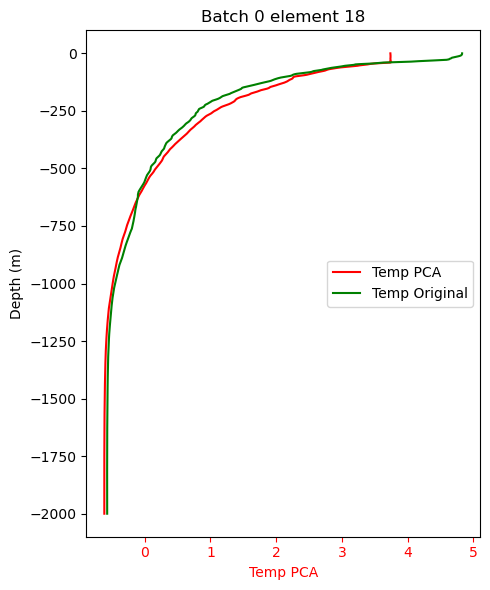

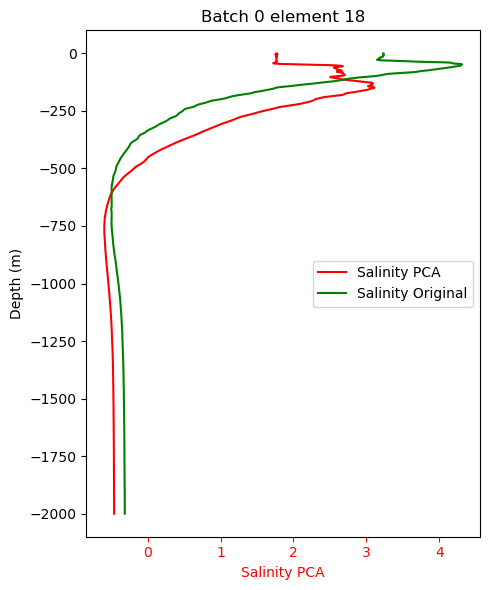

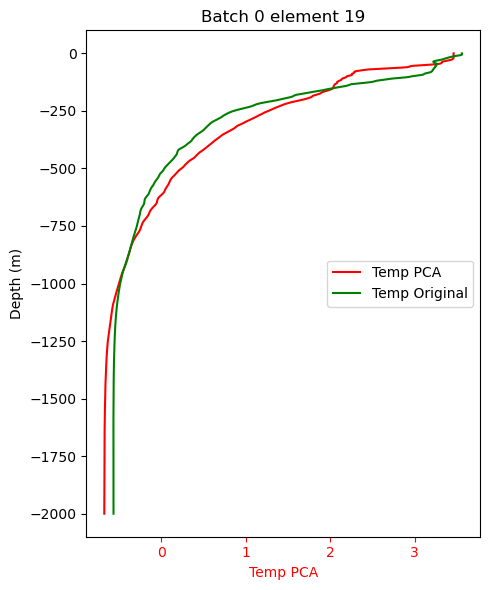

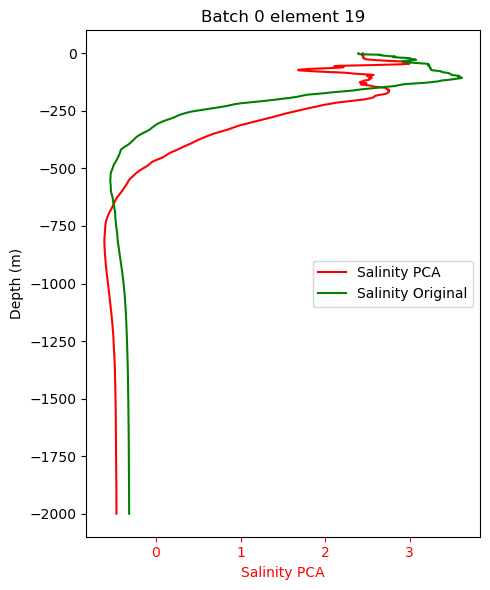

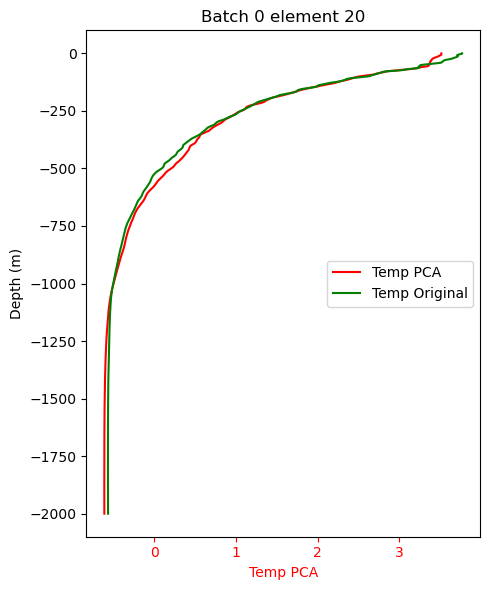

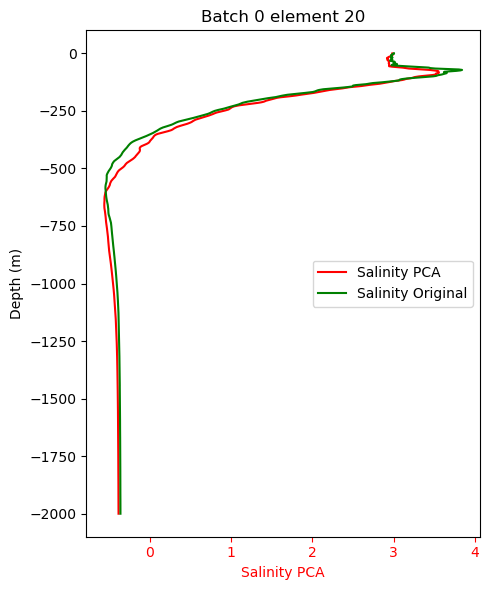

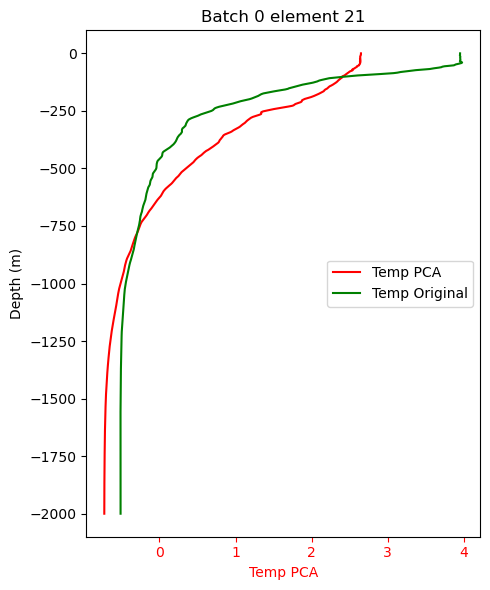

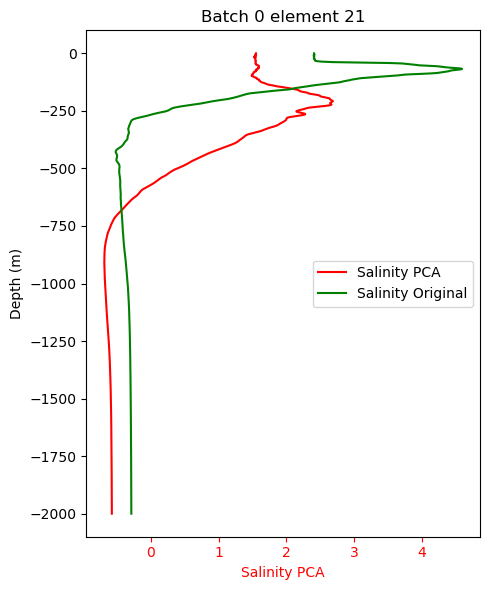

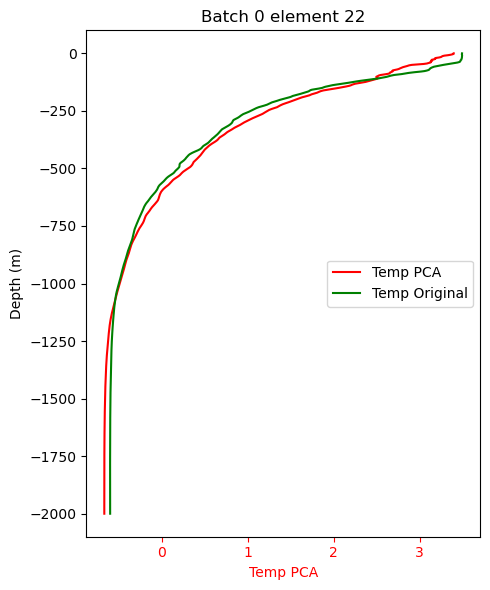

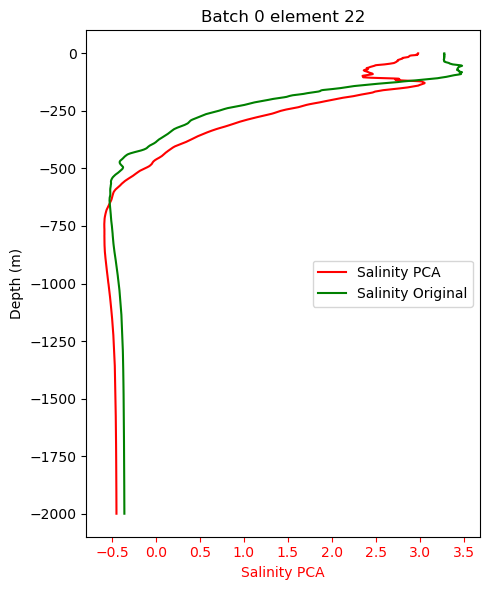

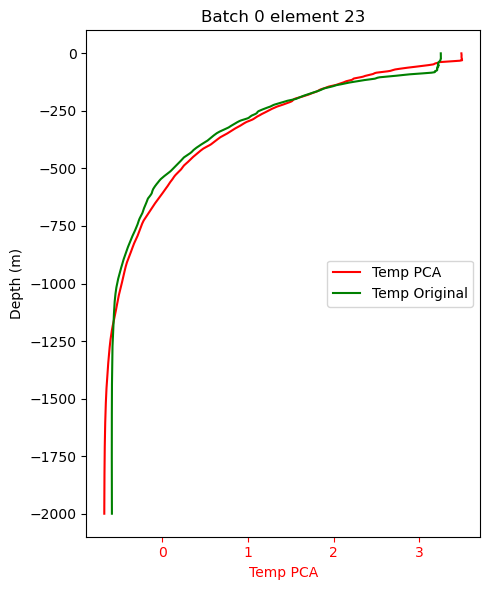

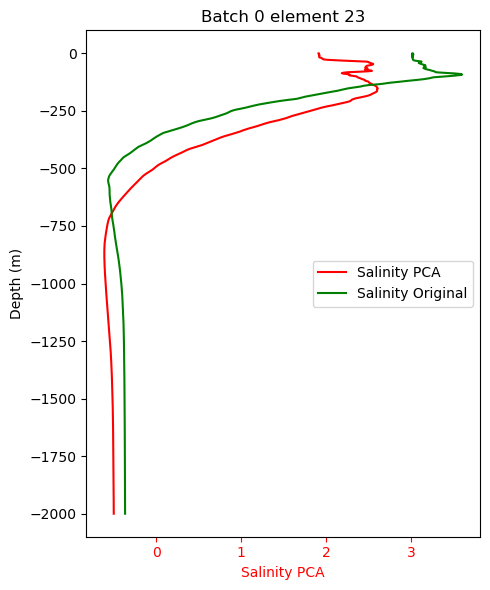

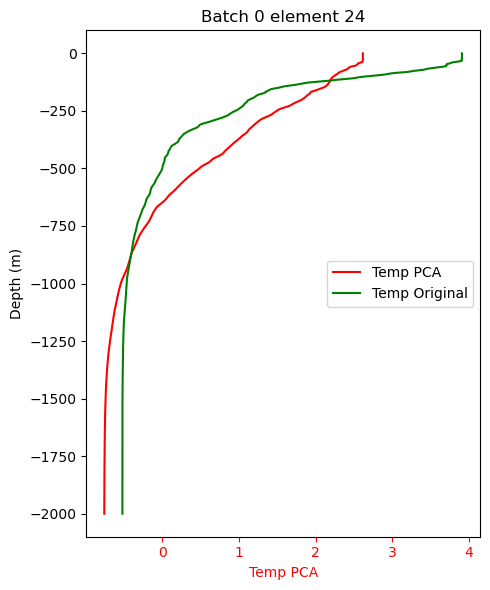

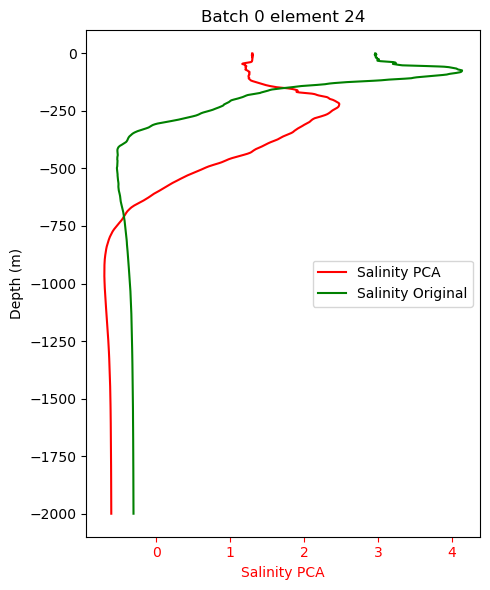

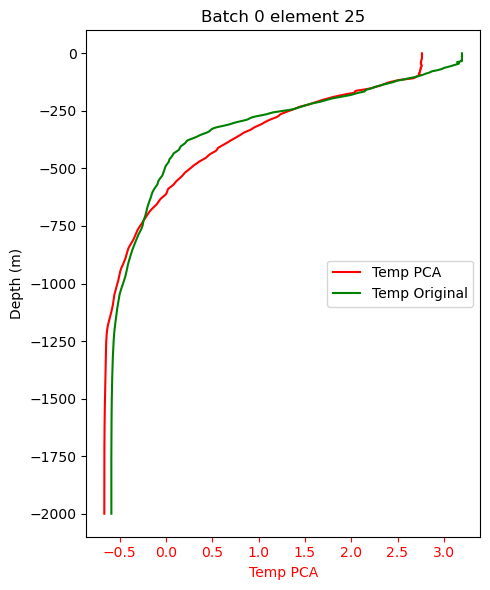

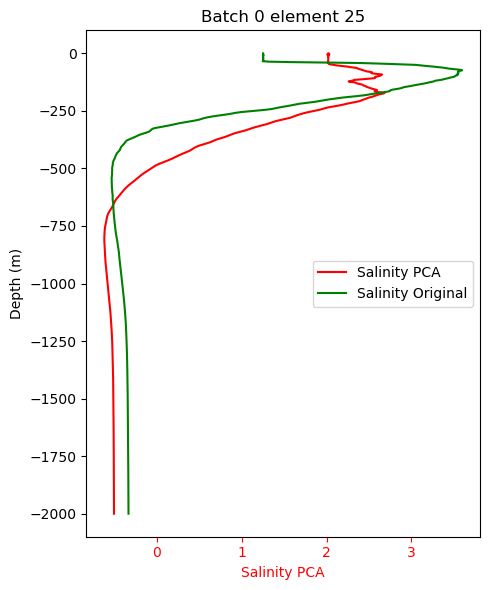

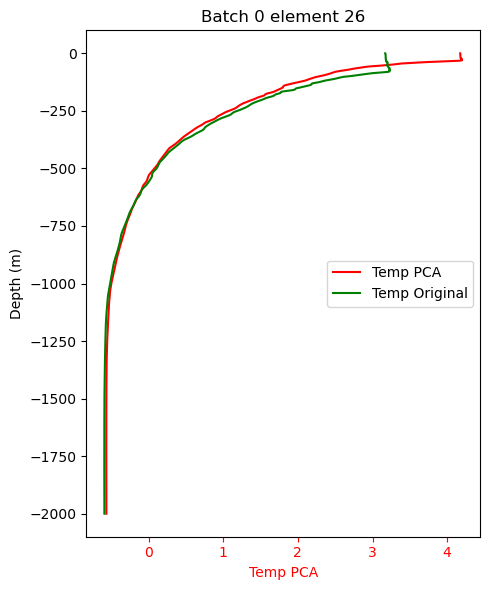

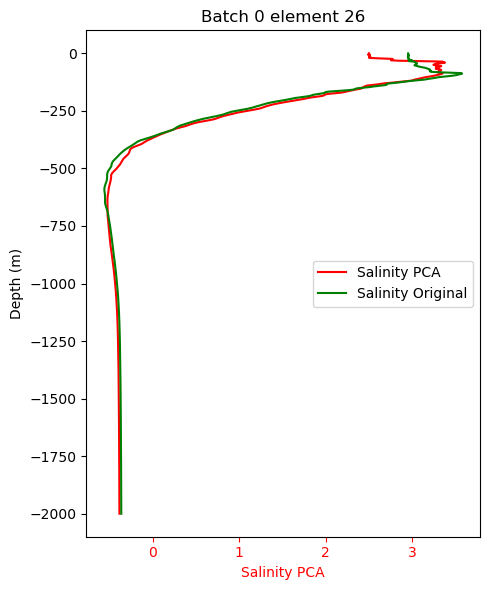

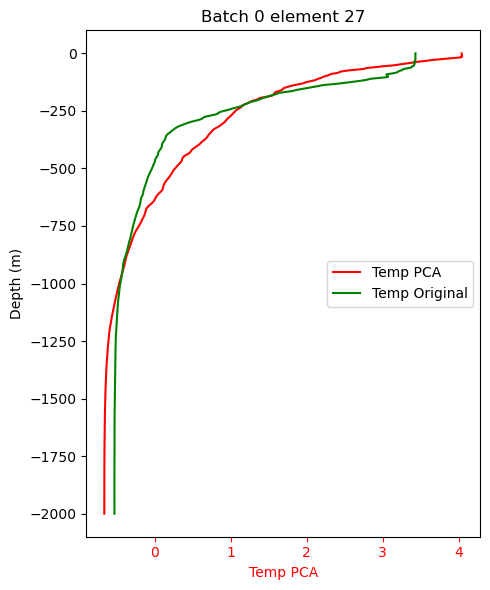

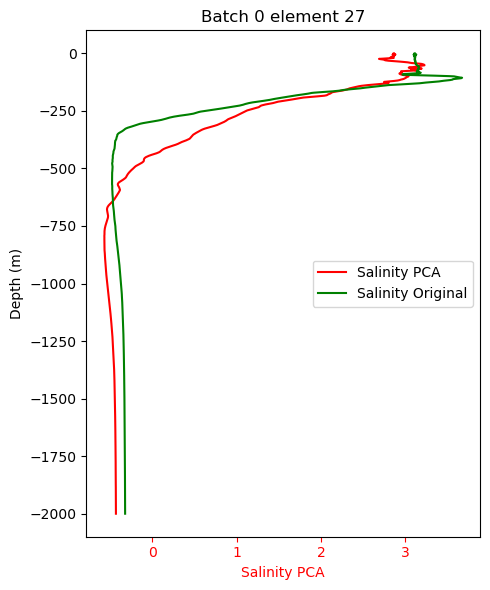

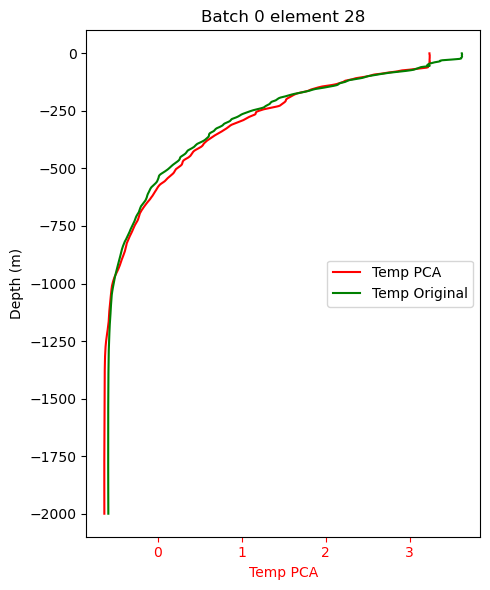

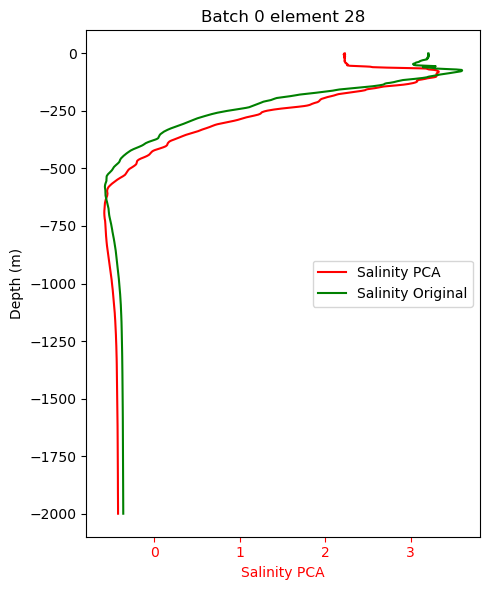

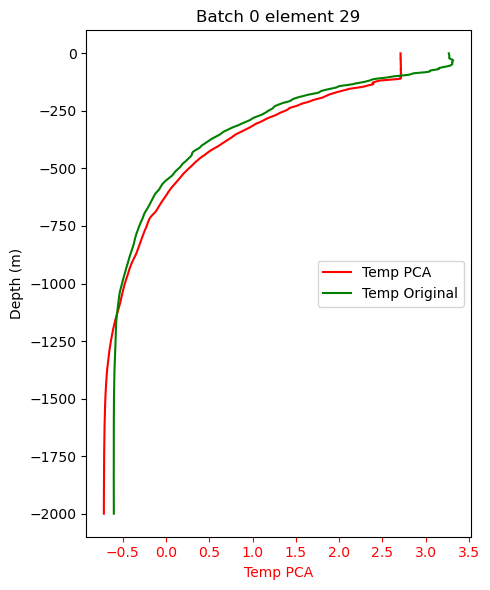

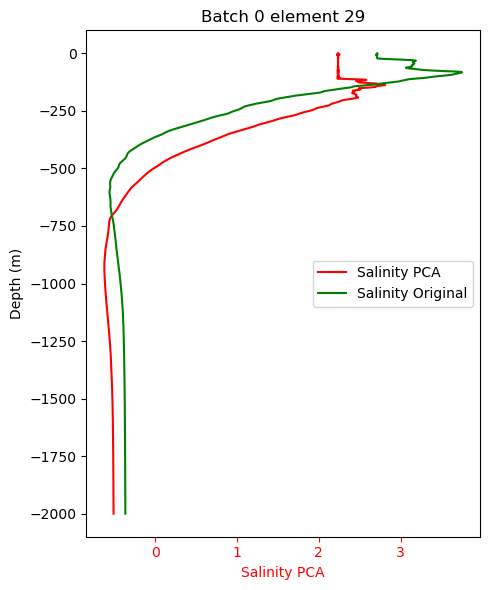

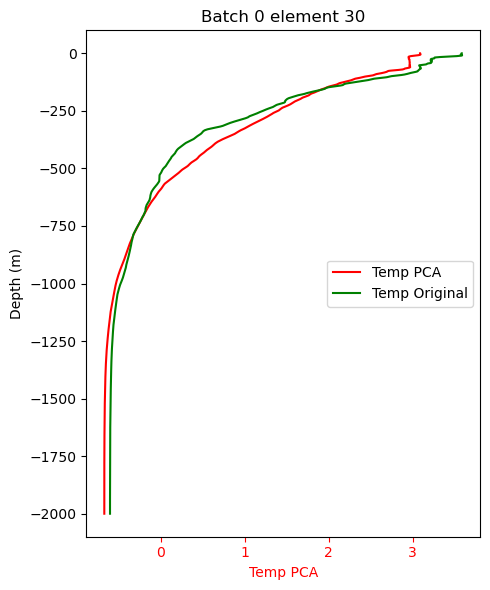

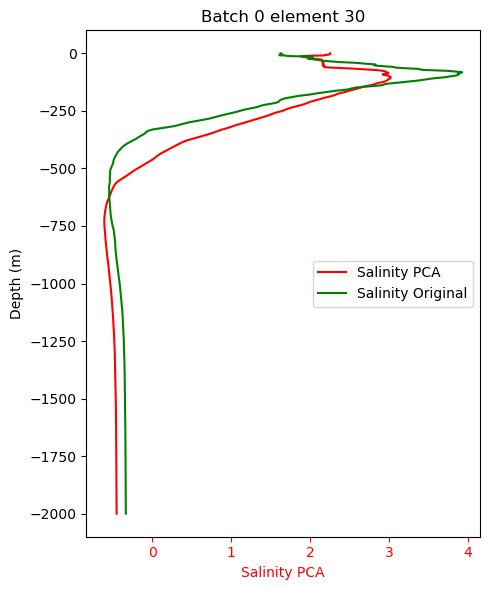

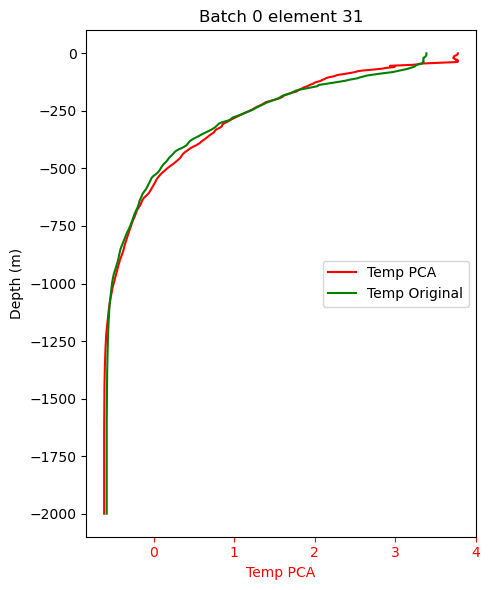

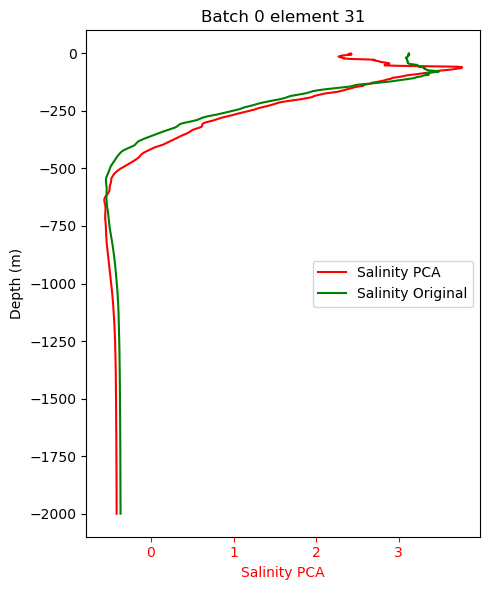

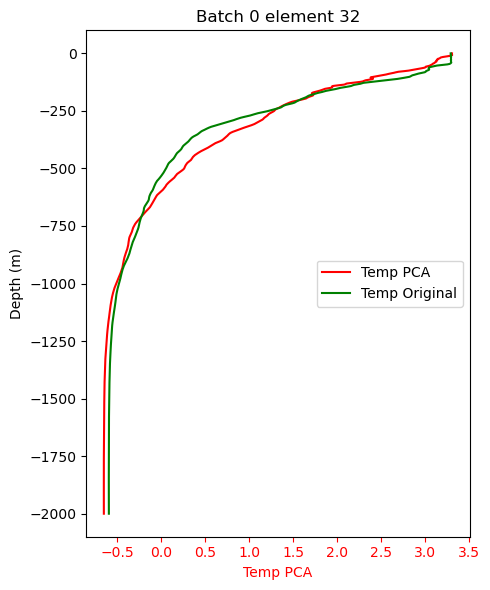

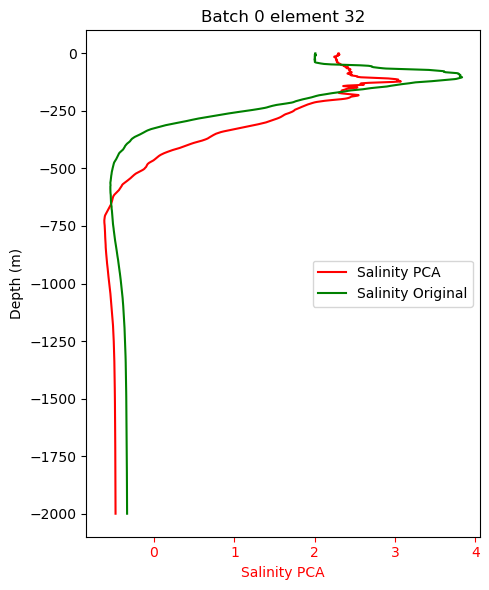

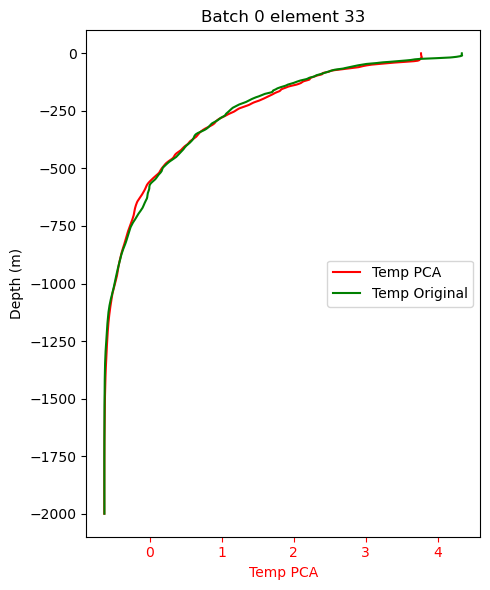

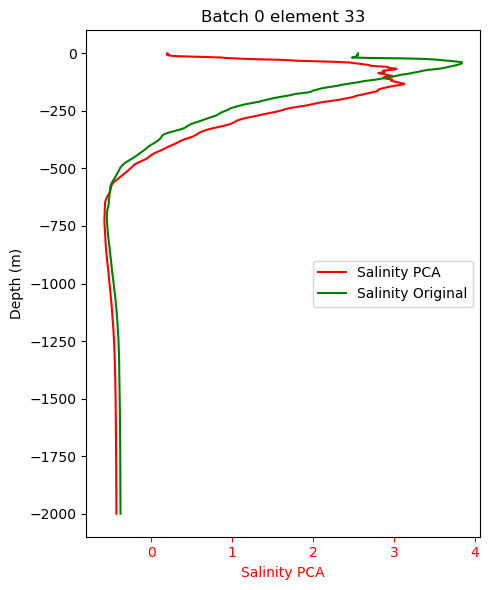

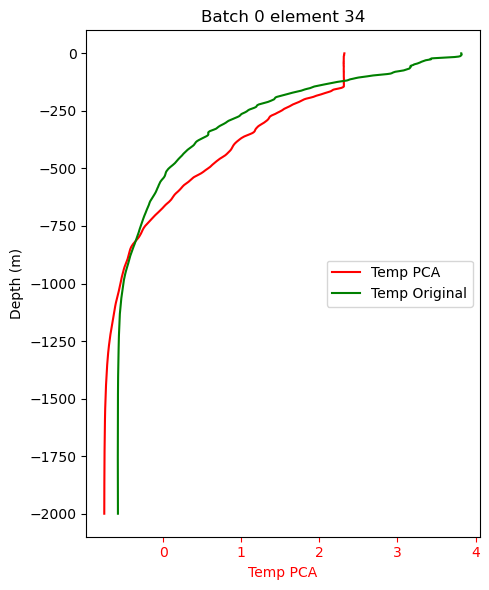

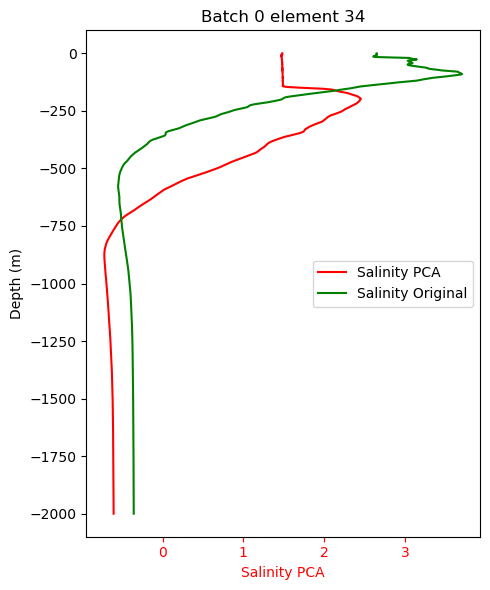

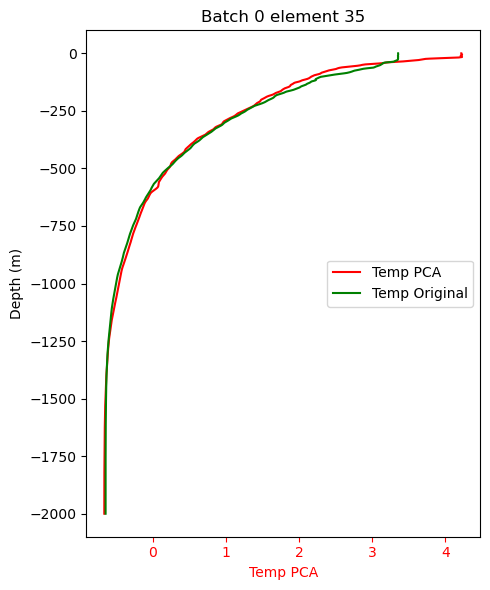

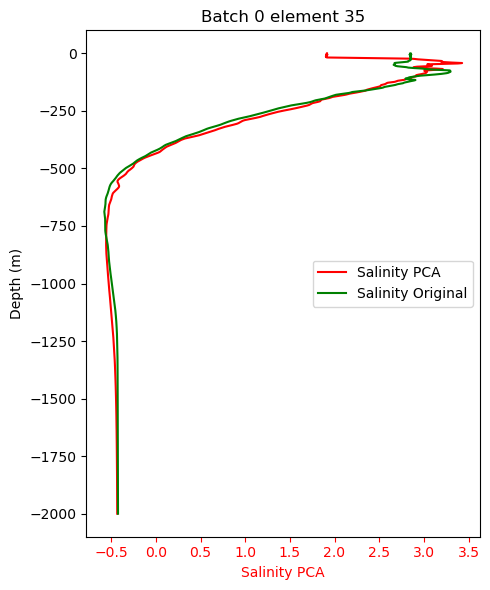

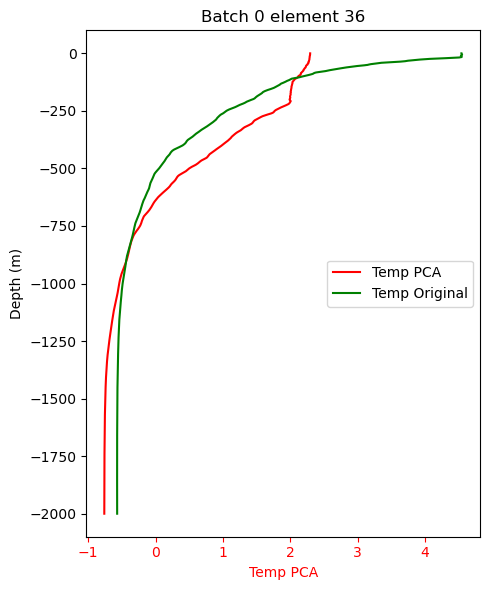

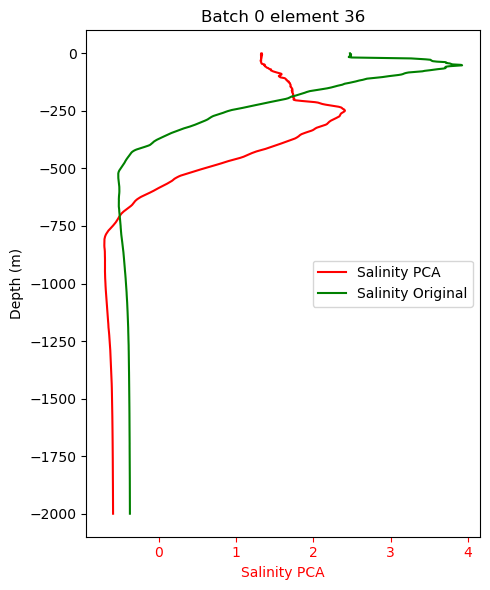

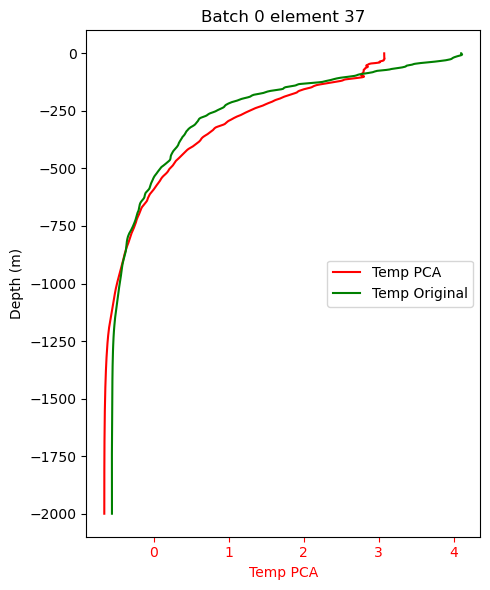

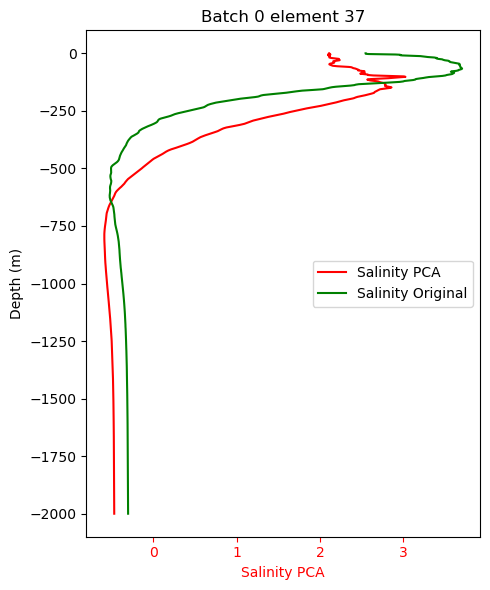

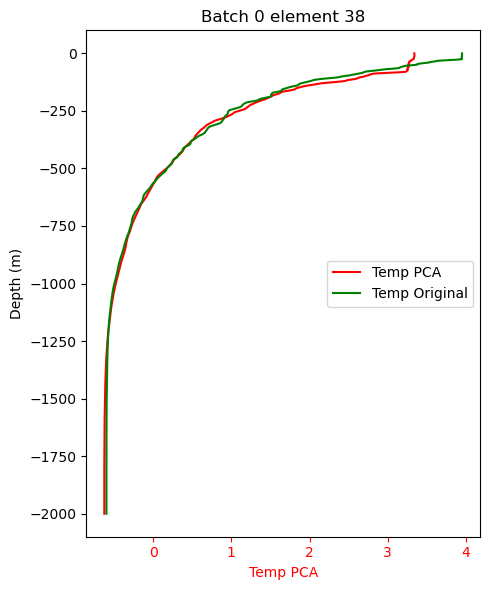

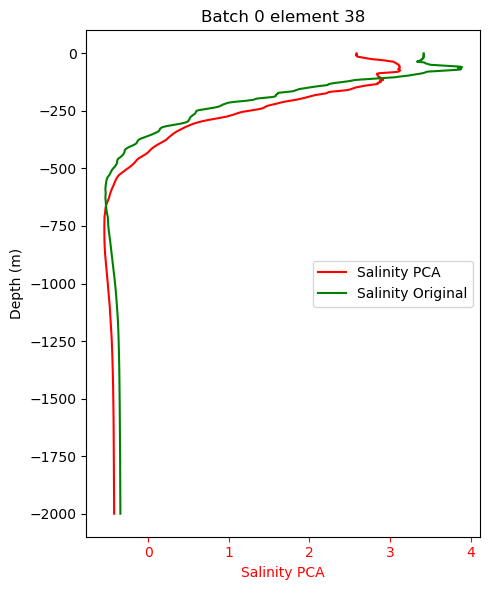

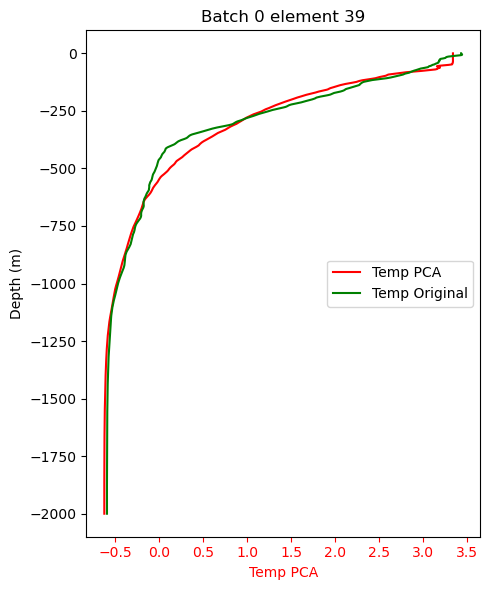

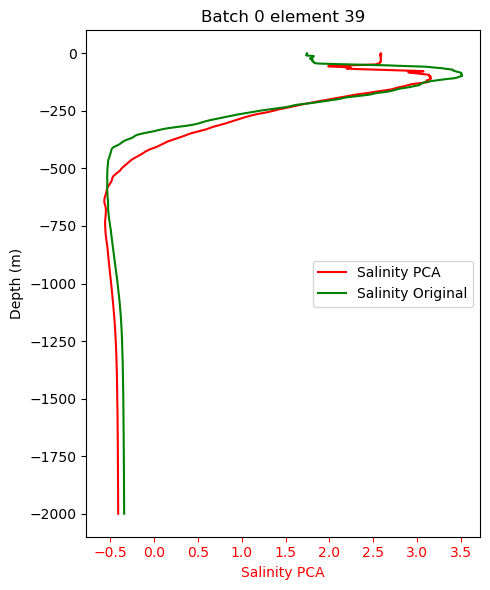

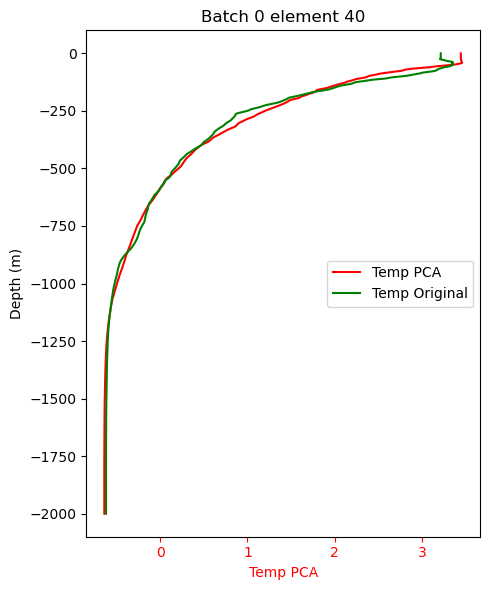

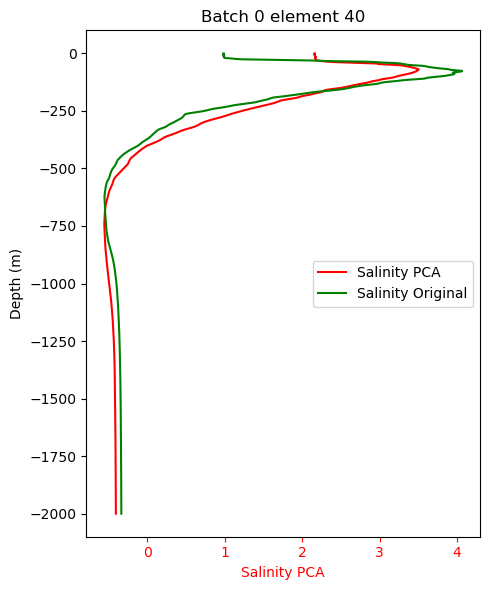

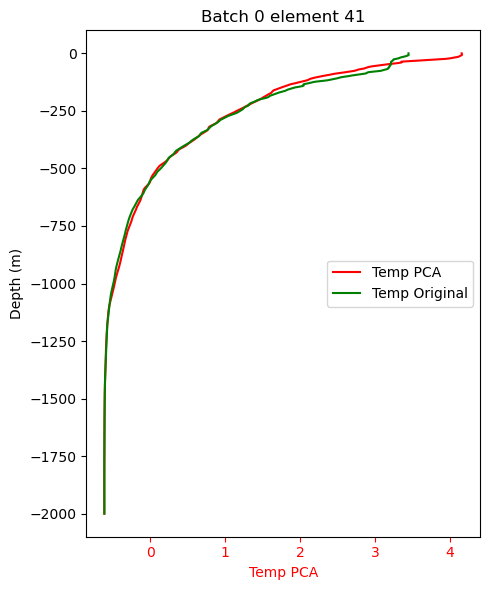

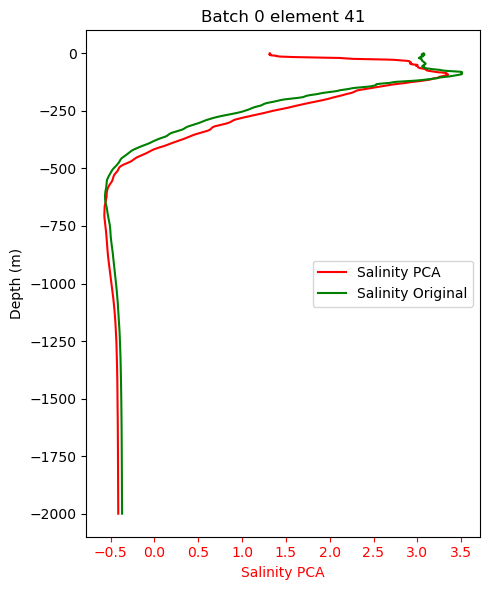

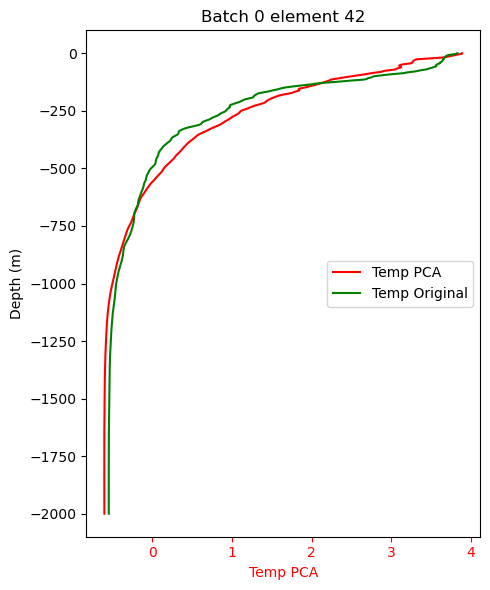

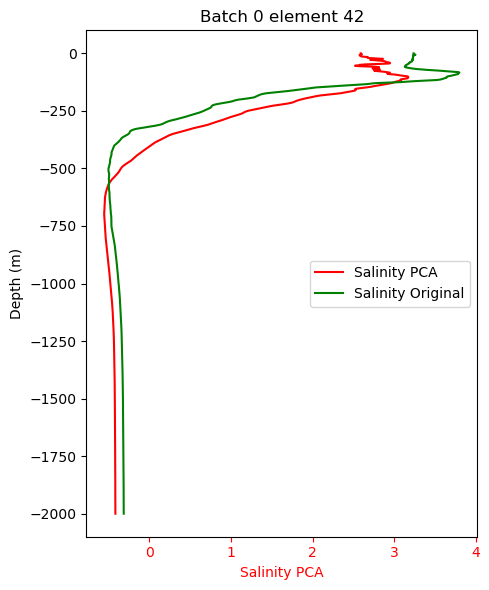

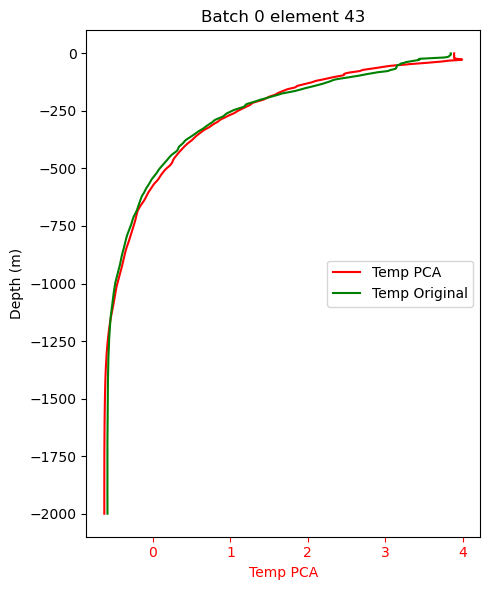

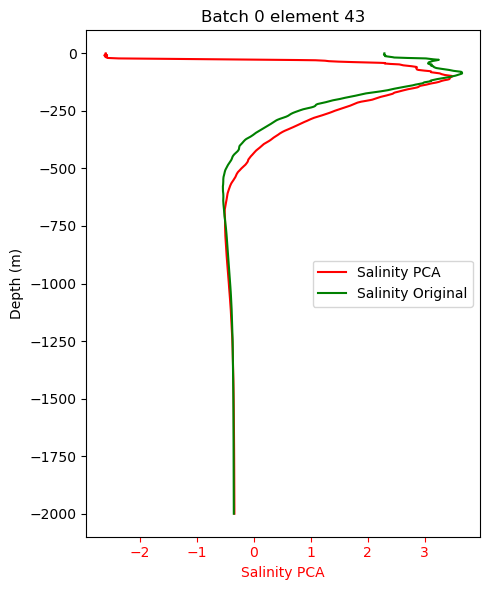

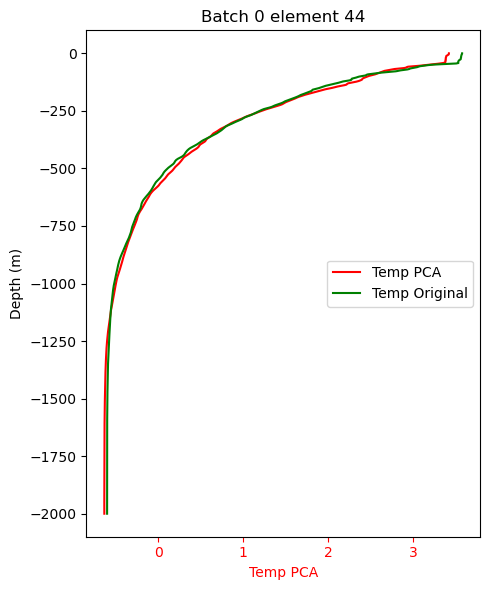

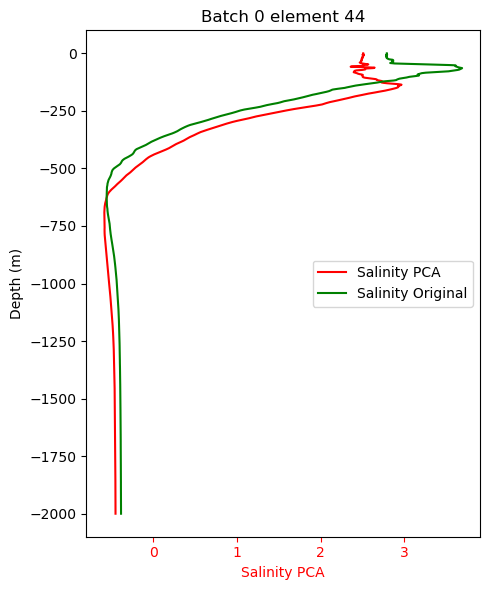

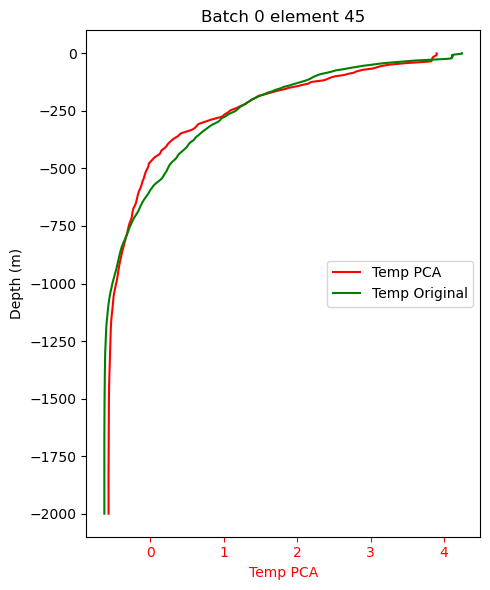

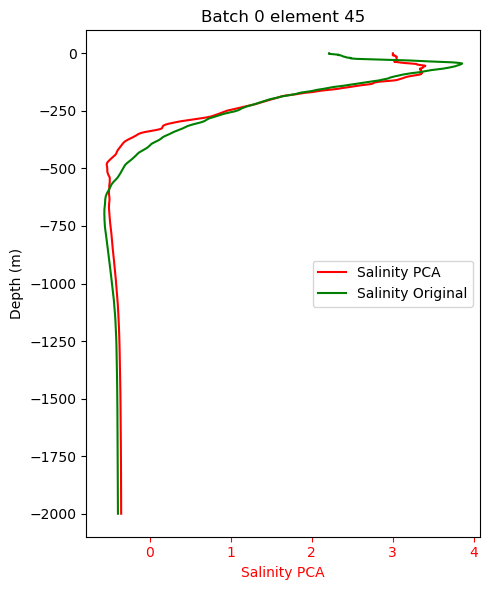

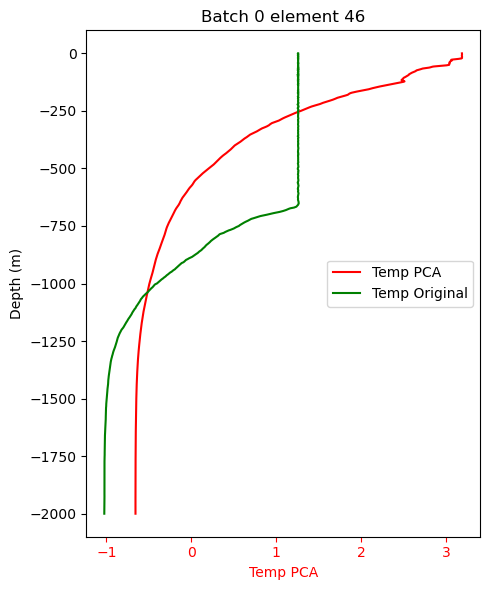

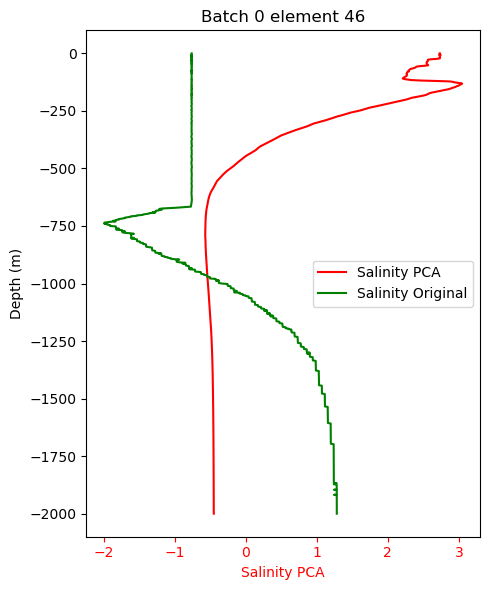

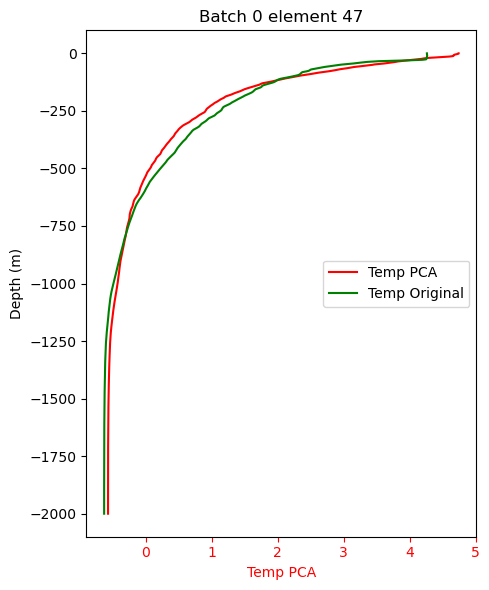

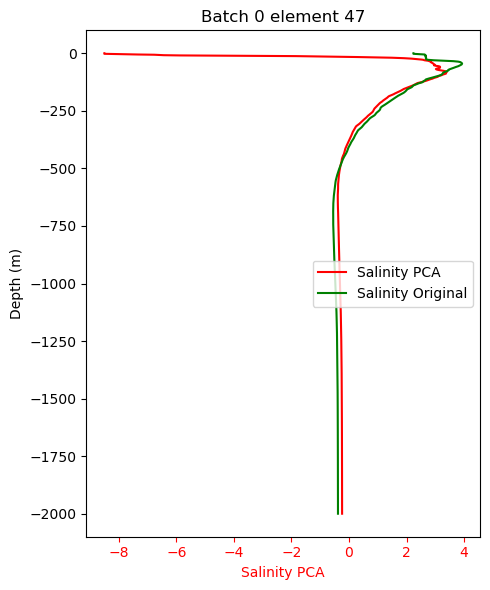

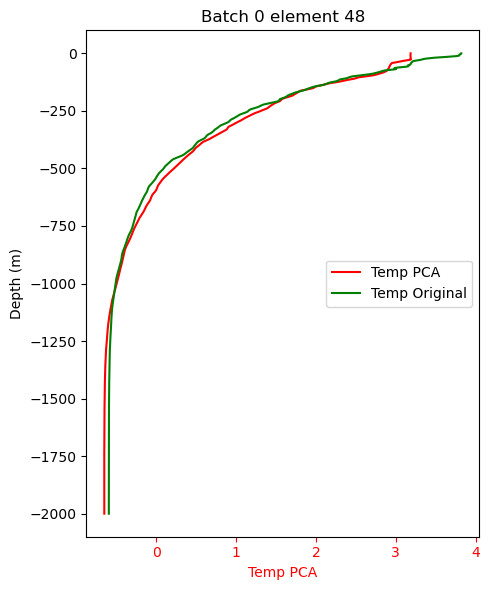

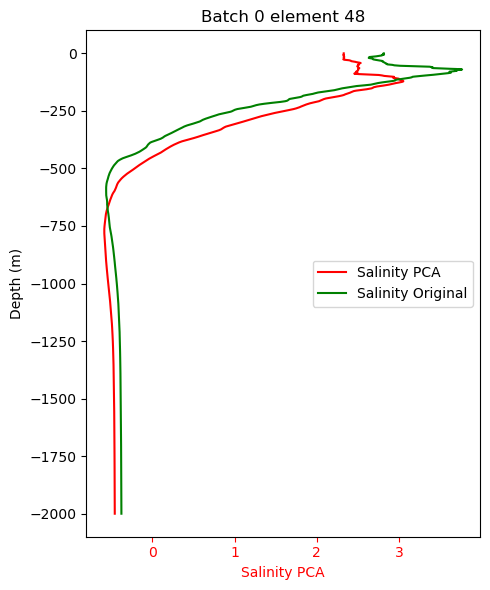

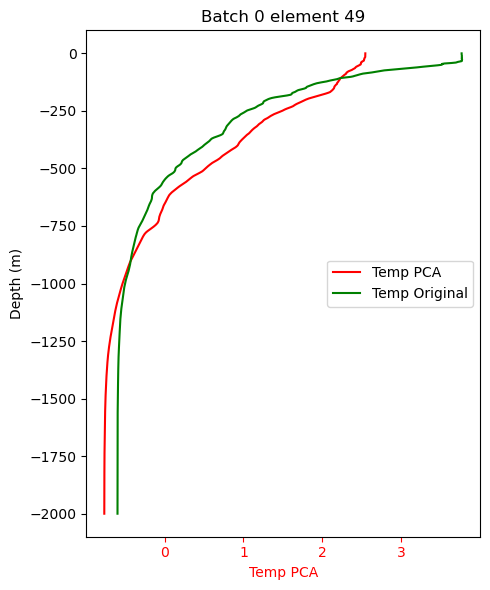

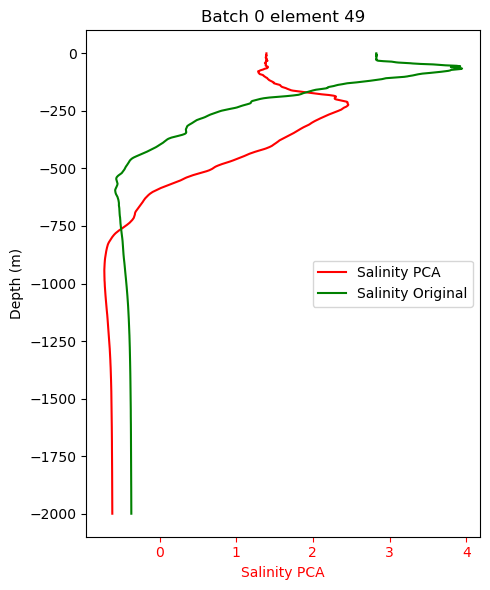

In [18]:
# dataset = revert_normalization(dataset, data_folder)
inoutdims = dataset.get_inout_dims()
for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(50):
    # for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

In [1]:
with_pca = False
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_ai.Training import train_model
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data, revert_normalization, revert_normalization_prof

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

2023-09-04 11:41:44.544482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 11:41:45.158392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyboardInterrupt: 

In [ ]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

: 

In [ ]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

: 

In [ ]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

: 

In [ ]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 2
neurons_per_layer = 400
# activation_hidden =  # tanh, sigmoid # 'relu'
# activation_hidden = 'sigmoid' #best for NoPCA
activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

: 

In [ ]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

: 

In [ ]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

: 

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    predictions = model(inputs.to(device))
    print("Predictions Shape:", predictions.shape)

# Comparing prediction to actual label for the first data point and save
plt.figure()
plt.plot(predictions[0].cpu().numpy(), label="Prediction", linewidth=0.3, color="red")
plt.plot(labels[0].numpy(), label="Ground Truth", linewidth=0.3, color="blue")
plt.legend()
plt.grid()
plt.title("Prediction VS Ground Truth - First case - " + model_name)
plt.savefig('comparison_' + model_name+ '.png', dpi=600)
plt.close()

: 

In [ ]:
# dataset = revert_normalization(dataset, data_folder)
inoutdims = dataset.get_inout_dims()
for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(50):
    # for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

: 